### Provide by

นายธนชาติ เสถียรจารุการ 63340500021 <br>

นายพชพล เพชรรัตน์ 63340500036

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import QuantileTransformer
import math

RandomState = 1
df = pd.read_csv('credit_card_churn.csv')
df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'CLIENTNUM'], axis=1)
df = df.rename(columns={'Attrition_Flag': 'y',
                         'Customer_Age': 'age',
                         'Gender': 'gender',
                         'Dependent_count': 'dependency',
                         'Education_Level': 'education',
                         'Marital_Status': 'marital',
                         'Income_Category': 'income',
                         'Card_Category': 'card',
                         'Months_on_book': 'book_period',
                         'Total_Relationship_Count': 'total_product',
                         'Months_Inactive_12_mon': 'month_inactive',
                         'Contacts_Count_12_mon': 'contact_num',
                         'Credit_Limit': 'credit_limit',
                         'Total_Revolving_Bal': 'revolving_balance',
                         'Avg_Open_To_Buy': 'open2buy',
                         'Total_Amt_Chng_Q4_Q1': 'transaction_change',
                         'Total_Trans_Amt': 'transaction_amount',
                         'Total_Trans_Ct': 'transaction_count',
                         'Total_Ct_Chng_Q4_Q1': 'transaction_count_change',
                         'Avg_Utilization_Ratio': 'utilization_ratio',
                         }
)
df['y'] = df['y'].replace(['Attrited Customer', 'Existing Customer'], [0, 1])

### Data exploration

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   y                         10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependency                10127 non-null  int64  
 4   education                 10127 non-null  object 
 5   marital                   10127 non-null  object 
 6   income                    10127 non-null  object 
 7   card                      10127 non-null  object 
 8   book_period               10127 non-null  int64  
 9   total_product             10127 non-null  int64  
 10  month_inactive            10127 non-null  int64  
 11  contact_num               10127 non-null  int64  
 12  credit_limit              10127 non-null  float64
 13  revolving_balance         10127 non-null  int64  
 14  open2b

##### Target
The total number of data is 10,127 samples devided into
- Attrited: 8,500 samples
<br>

- Existing: 1,627 samples

**the dataset is imbalanced**

1    8500
0    1627
Name: y, dtype: int64


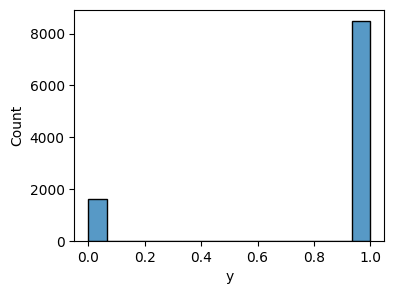

major target: 83.93%


In [3]:
count = df['y'].value_counts(); print(count)
plt.figure(figsize = (4, 3))
sns.histplot(data = df, x = 'y')
plt.show()
print(f"major target: {(count[1]/(count[0] + count[1])) * 100:0.2f}%")

##### resample data

1    8500
0    8500
Name: y, dtype: int64


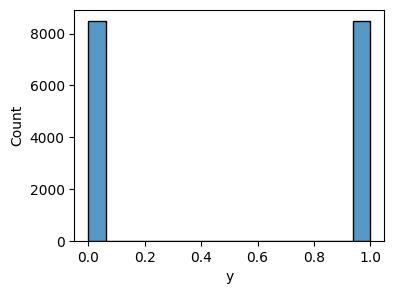

major target: 50.00%


In [4]:
major_target = df.loc[df['y'] == 1]
minor_target = df.loc[df['y'] == 0]
upsampling_df = resample(minor_target, n_samples=major_target.shape[0], replace=True, random_state=RandomState)
df = pd.concat([major_target, upsampling_df], ignore_index=True)
df = df.sample(frac = 1, ignore_index=True)

count = df['y'].value_counts(); print(count)
plt.figure(figsize = (4, 3))
sns.histplot(data = df, x = 'y')
plt.show()

print(f"major target: {(count[1]/(count[0] + count[1])) * 100:0.2f}%")

##### Explore numerical data

the data that seem to have an outlier is listed below
- age
- transaction_change
- transaction_count_change

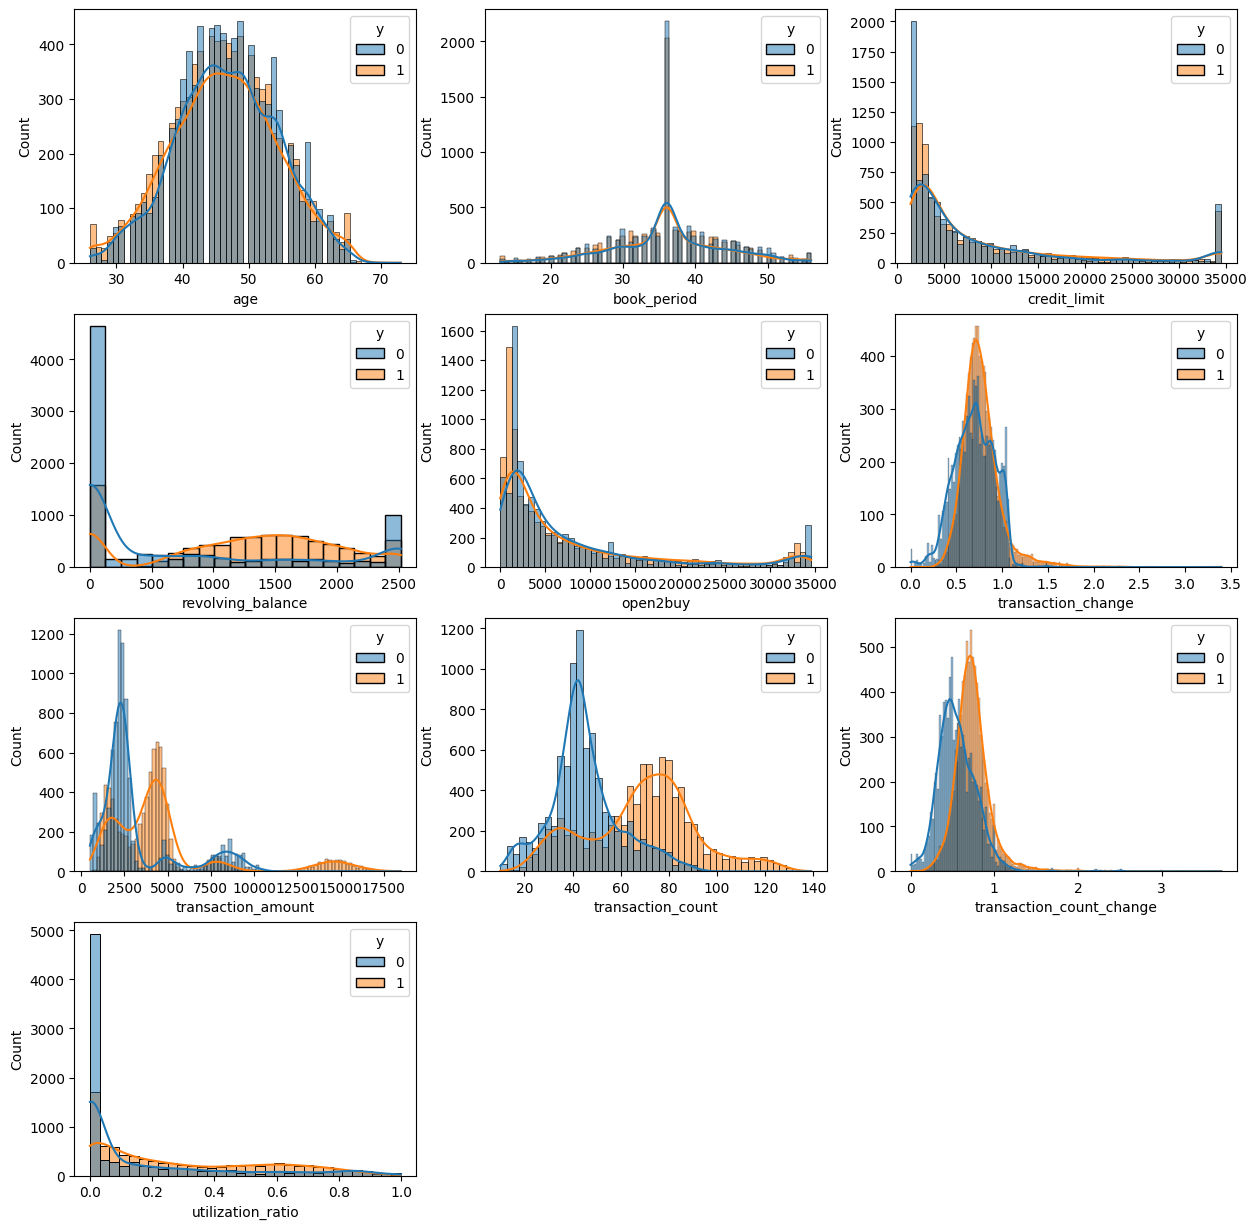

In [5]:
def seperateDataType(df): ## return list of numerical and categorical data
    cols = df.columns
    num_data = [i for i in cols if (len(df[i].unique()) > 7 and df[i].dtype != 'object')]
    cat_data = list(set(cols) - set(num_data))
    return num_data, cat_data

num_data, cat_data = seperateDataType(df)
plot_num = 1
plt.figure(figsize = (15,27))
for i in num_data:
    ax = plt.subplot(7, 3, plot_num)
    sns.histplot(data=df, x=i, hue='y', kde=True)
    plot_num += 1
plt.show()


- Use IQR to remove outlier

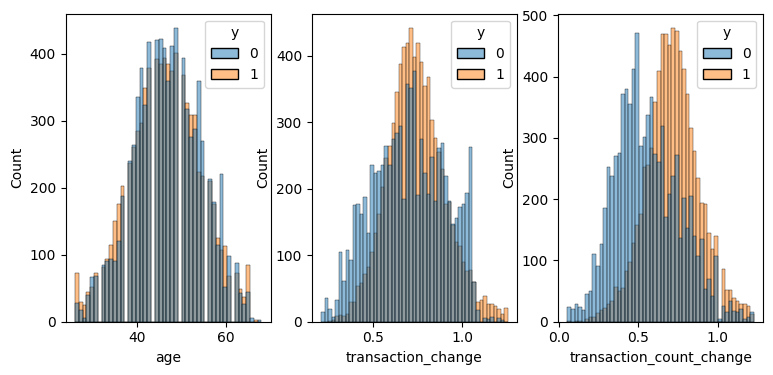

In [6]:
def removeNumericalOutlier(df:pd.DataFrame, feature_list:list):
    new_df = df.copy()
    for feature in feature_list:       
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        IQR = q3 - q1
        lower_bound = q1 - 1.5*IQR
        upper_bound = q3 + 1.5*IQR
        new_df = new_df[(new_df[feature]>lower_bound)&(new_df[feature]<upper_bound)]
    return new_df

outlier_list = ['age', 'transaction_change', 'transaction_count_change']
df = removeNumericalOutlier(df, outlier_list)

plot_num = 1
plt.figure(figsize = (9, 4))
for i in outlier_list:
    ax = plt.subplot(1, 3, plot_num)
    sns.histplot(data=df, x=i, hue='y')
    plot_num += 1
plt.show()

- Use quantile transformer to correct skewed data and standardlize

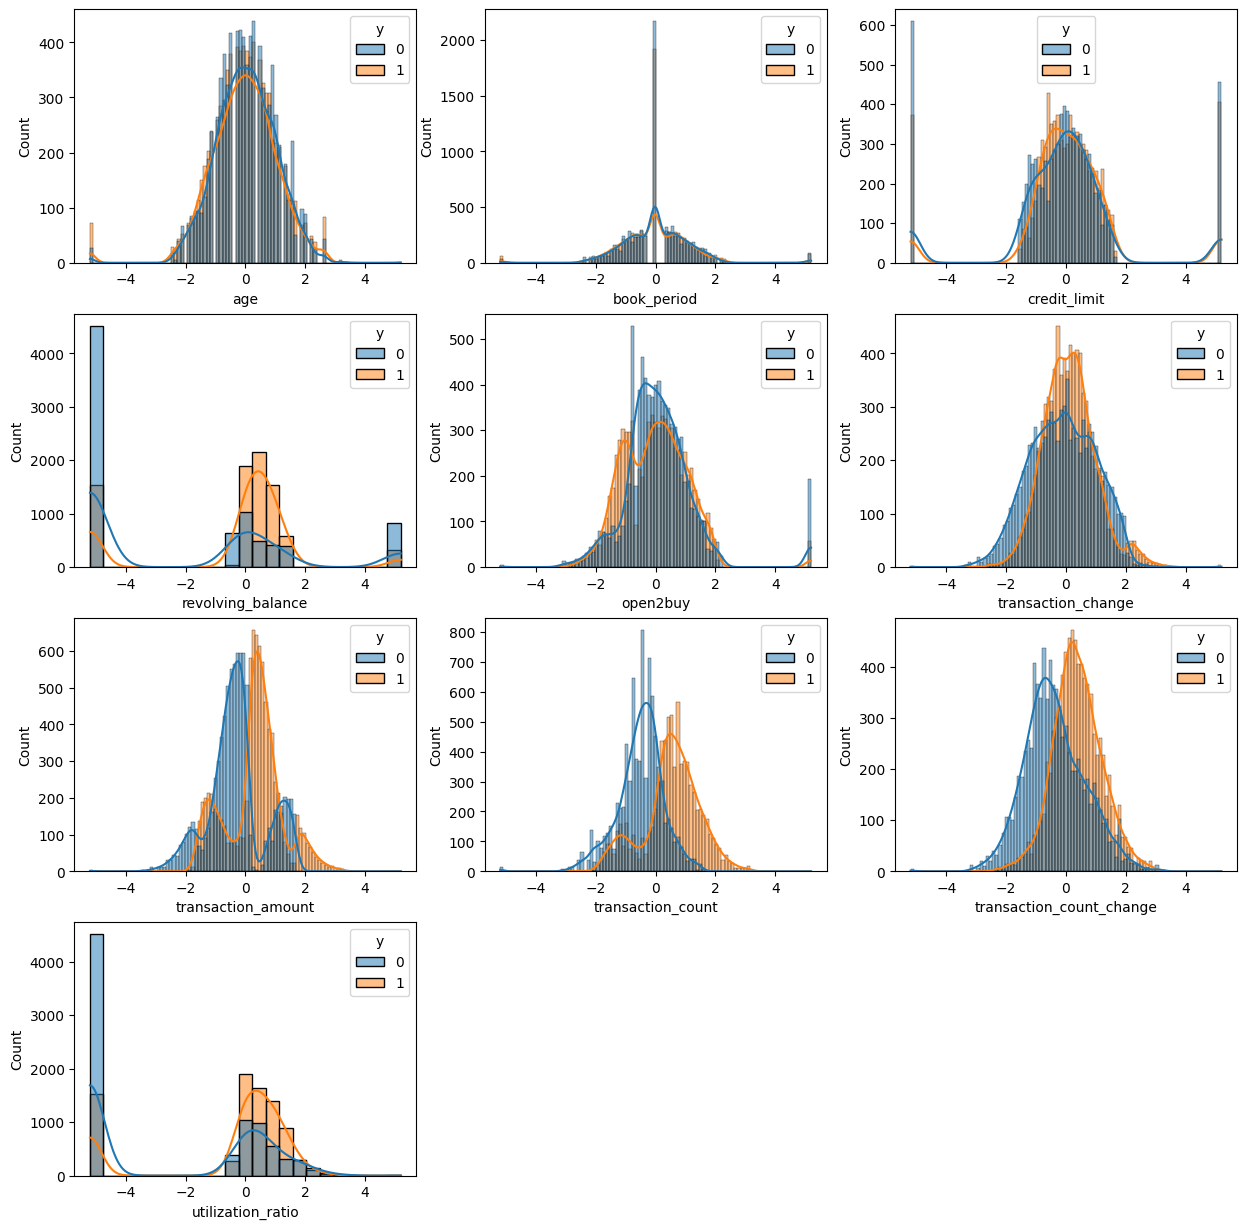

In [7]:
def correctSkewed(df:pd.DataFrame, skewed_data_list:list):
    ##### correct skewed data
    quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=1)
    x_skew = df[skewed_data_list].values
    X_trans = quantile_transformer.fit_transform(x_skew)
    df[skewed_data_list] = X_trans
    return df

df = correctSkewed(df, num_data)
plot_num = 1
plt.figure(figsize = (15,27))
for i in num_data:
    ax = plt.subplot(7, 3, plot_num)
    sns.histplot(data=df, x=i, hue='y', kde=True)
    plot_num += 1
plt.show()

- plot heatmap of numerical data correlation

c:\Users\thana\Desktop\TheShit\FRA503\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


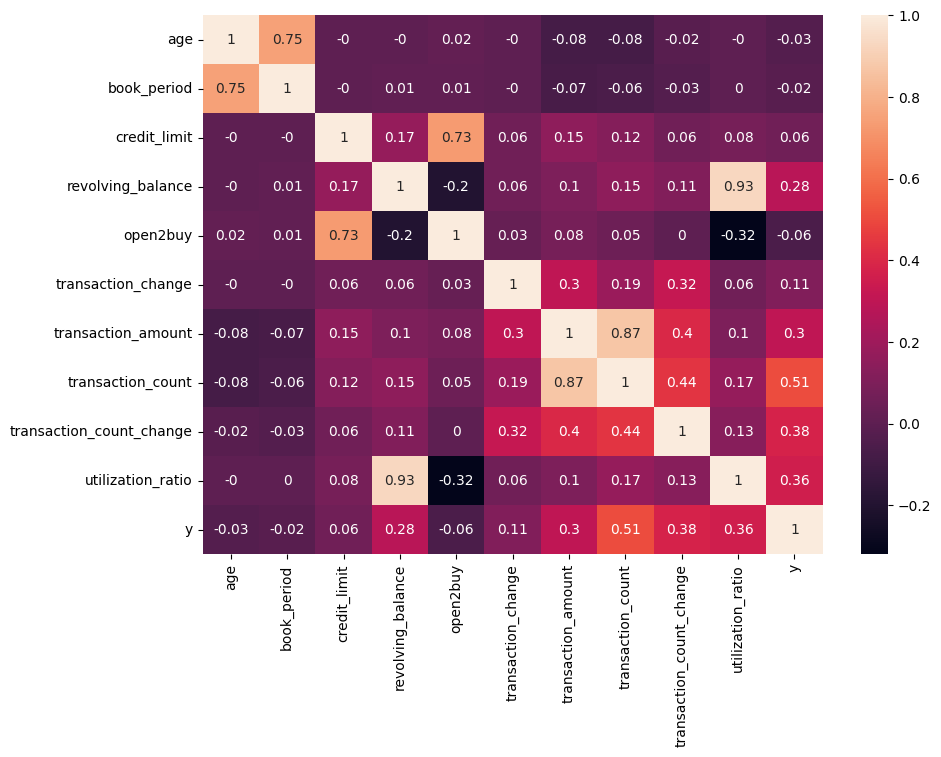

In [8]:
num_df = df[num_data]
num_df['y'] = df['y']
plt.figure(figsize = (10,7))
sns.heatmap(round(num_df.corr(), 2), annot=True)
plt.show()

- visualize high correlation to target
<br>

*the distribution of some data that have a high correlation to the target seems to be the same value as listed below but the pair between Transaction_amount and transaction_count we not sure how this relation effect to model and we consider testing in the training model session*

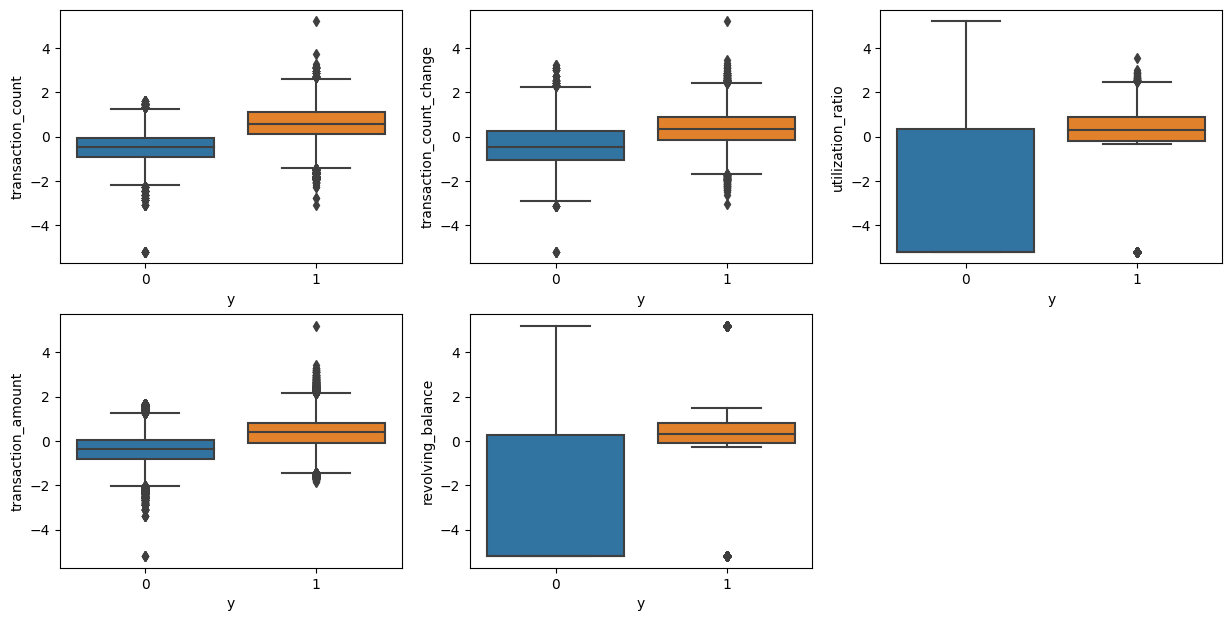

In [9]:
high_corr_data_list = ['transaction_count', 'transaction_count_change', 'utilization_ratio', 'transaction_amount', 'revolving_balance']
plot_num = 1
plt.figure(figsize = (15,27))
for i in high_corr_data_list:
    ax = plt.subplot(7, 3, plot_num)
    sns.boxplot(data=num_df, x='y', y=i)
    plot_num += 1
plt.show()

- visualize relation between numerical data

*the result is related to the correlation heatmap above, the pair with high correlation for each other show some mathematical function*

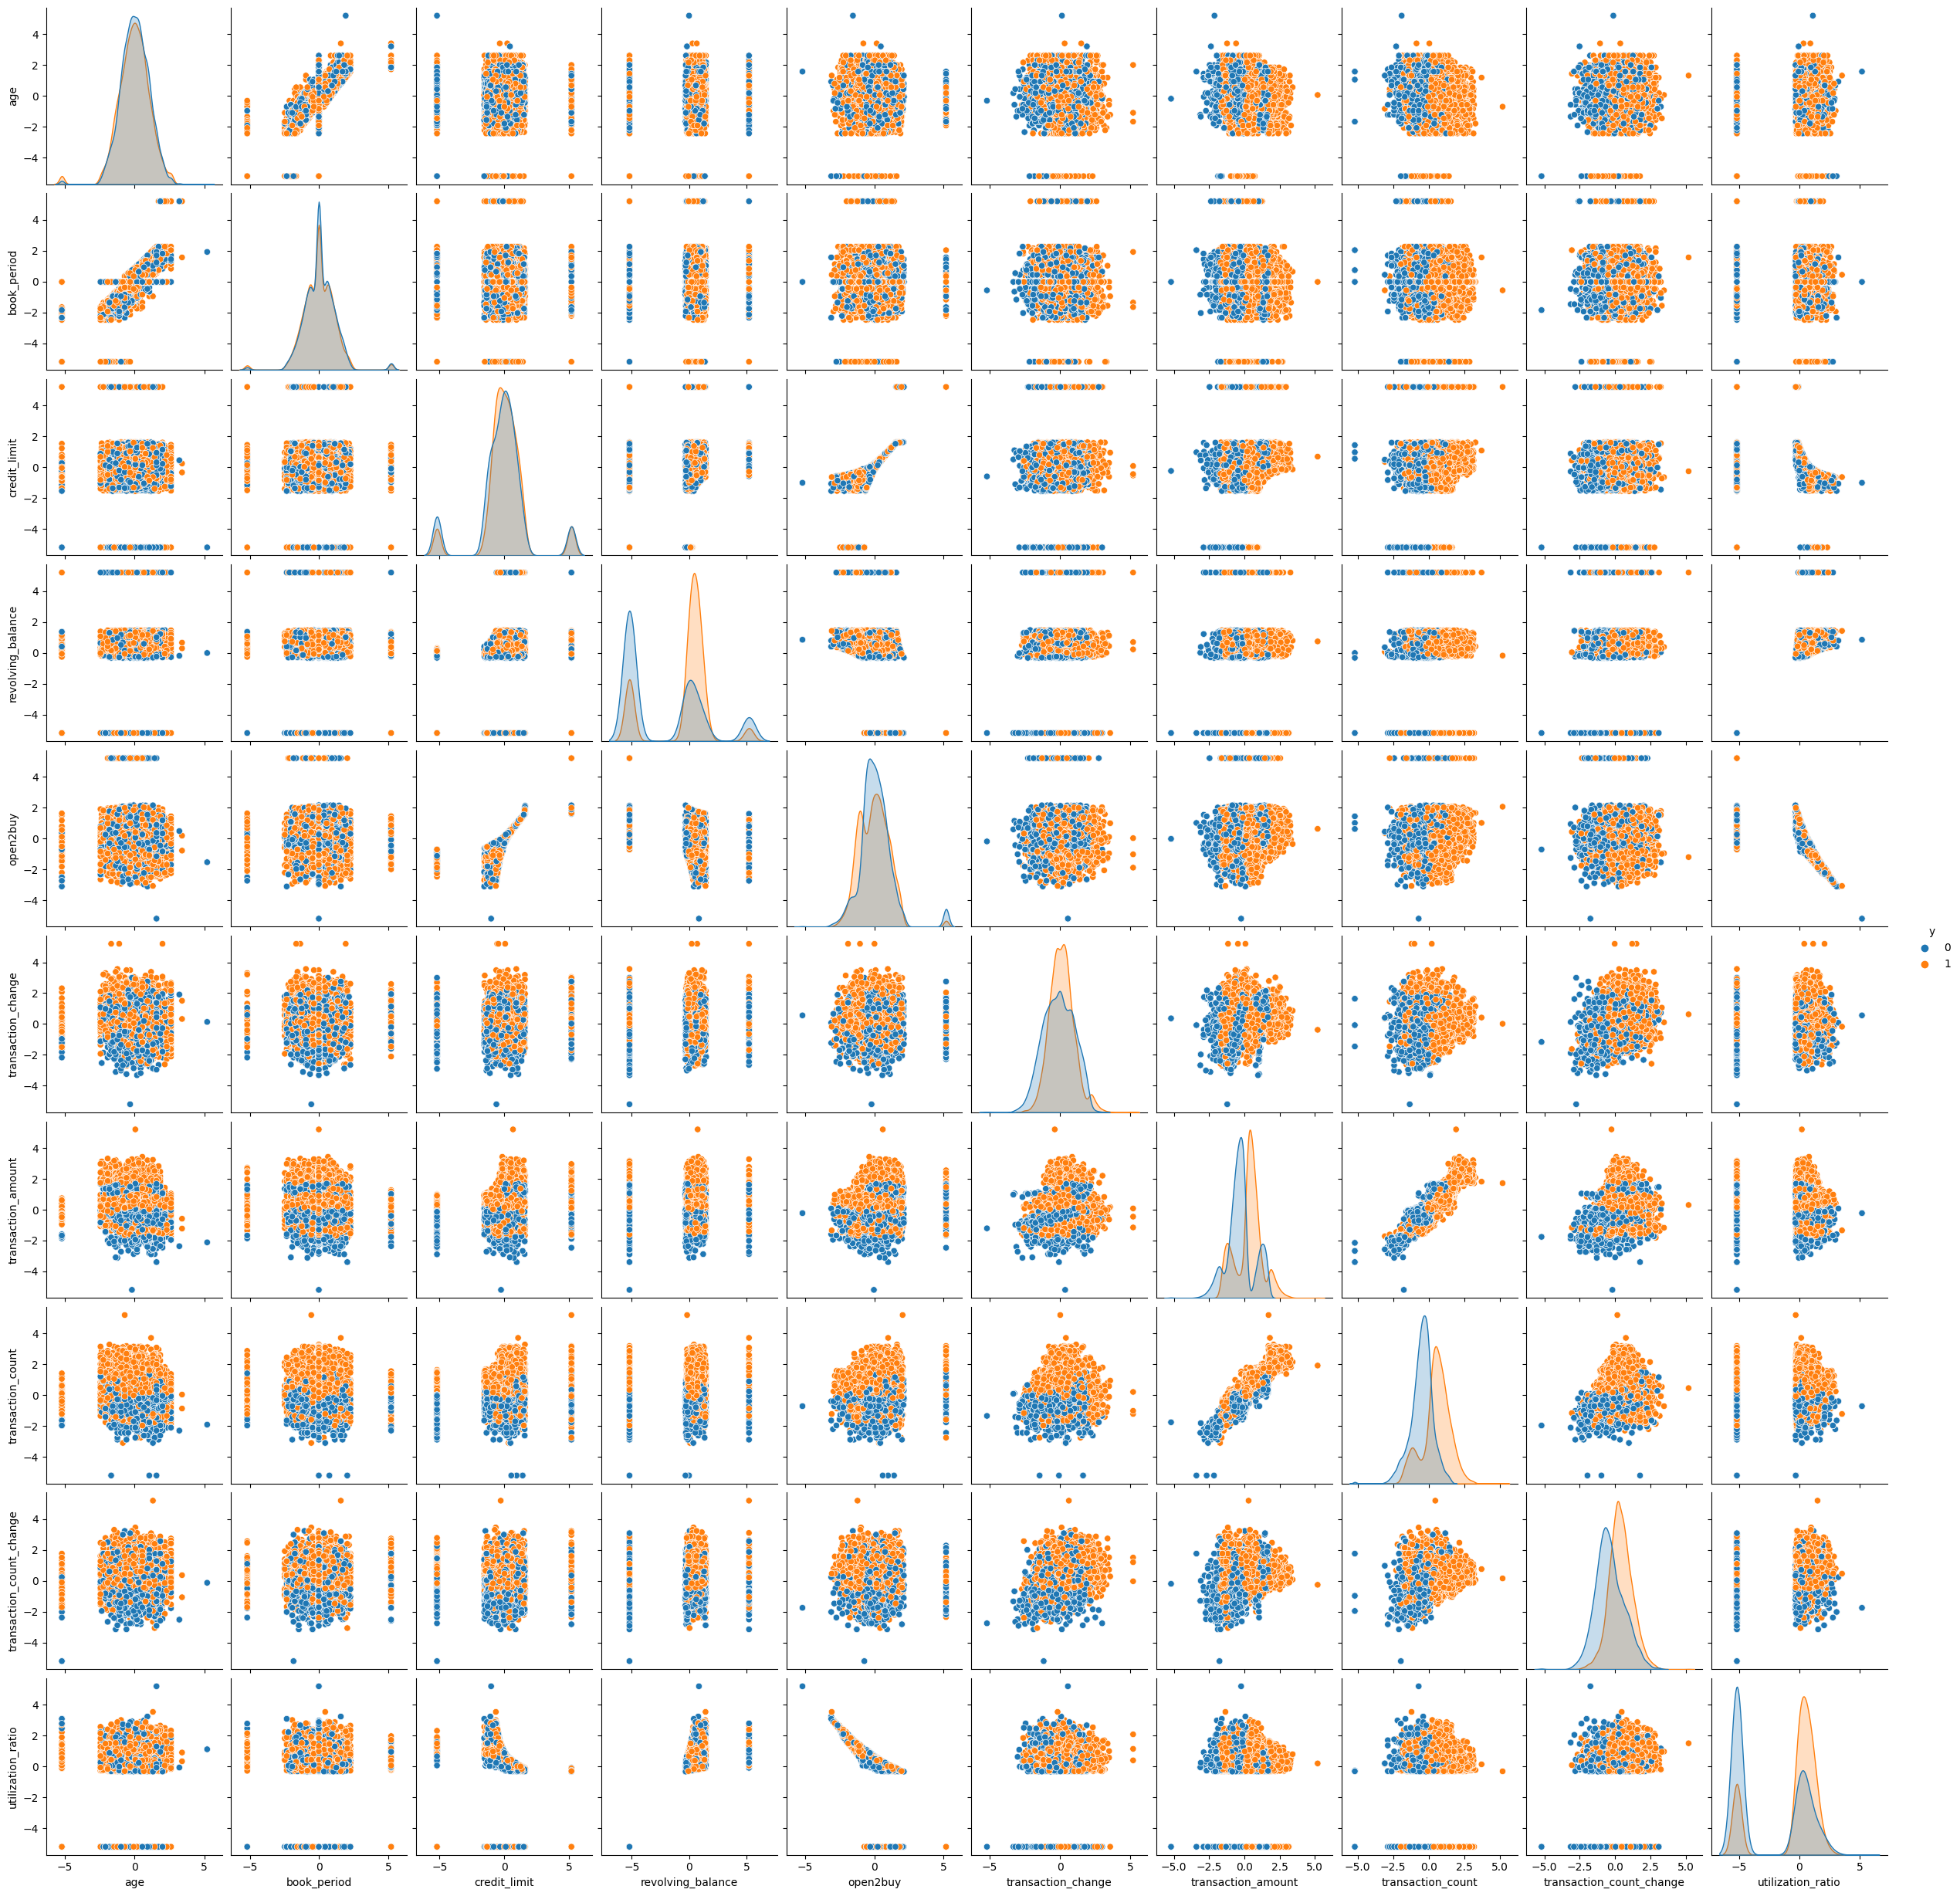

In [10]:
sns.pairplot(data=num_df, hue='y')
plt.show()

##### Explore categorical data

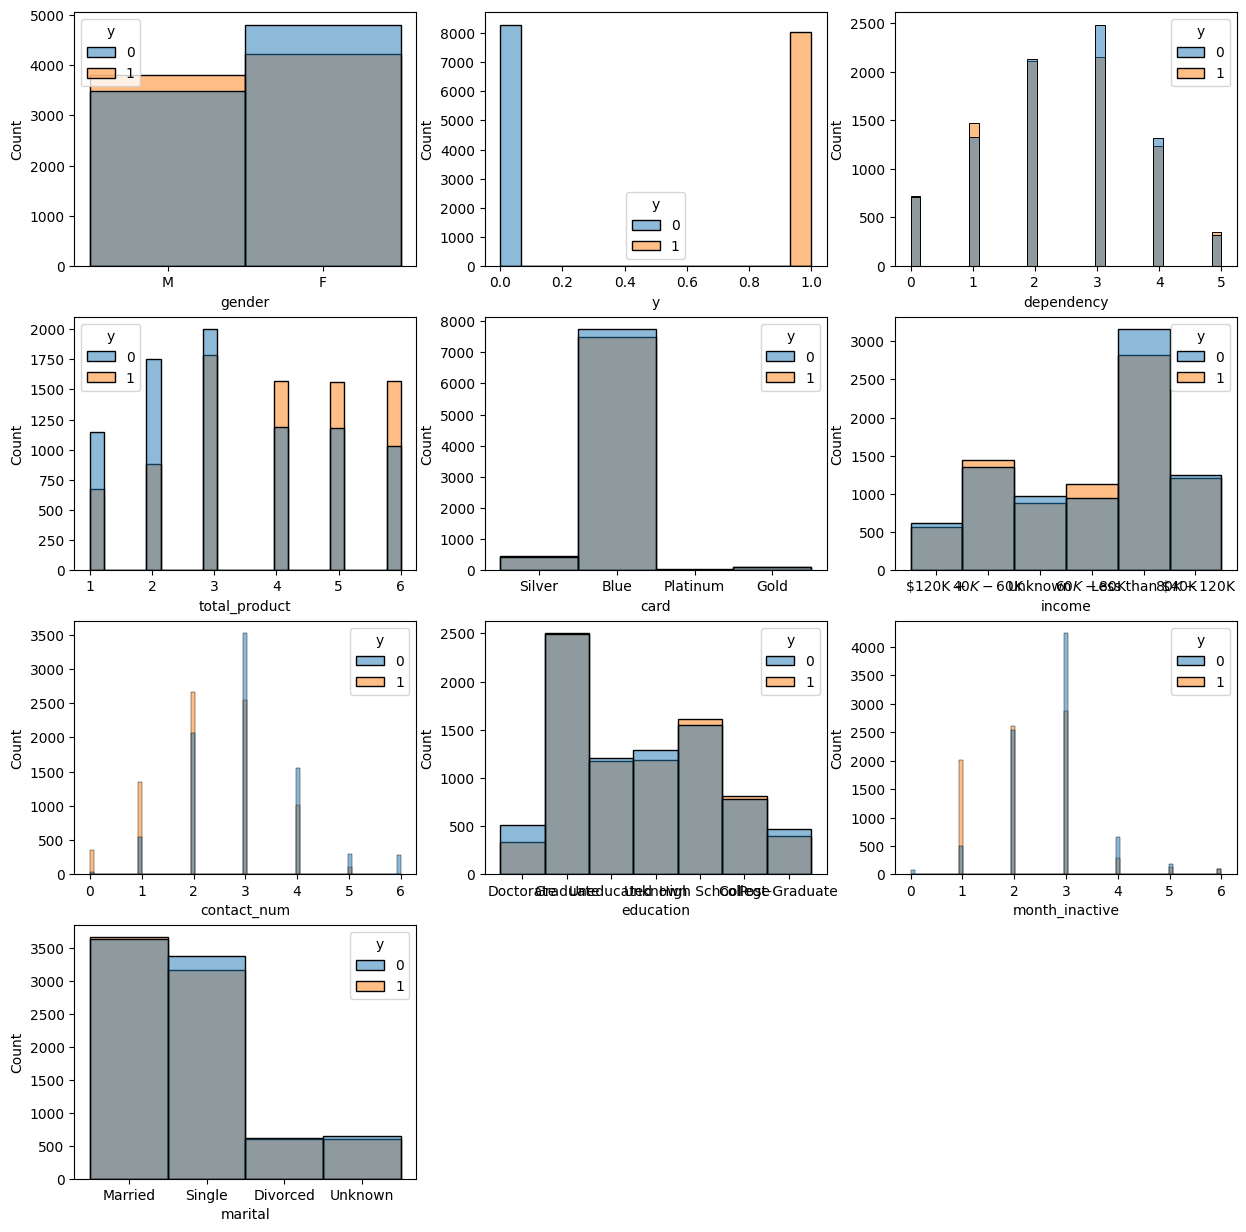

In [11]:
plot_num = 1
plt.figure(figsize = (15,27))
for i in cat_data:
    ax = plt.subplot(7, 3, plot_num)
    sns.histplot(data=df, x=i, hue='y')
    plot_num += 1
plt.show()

- group card category 

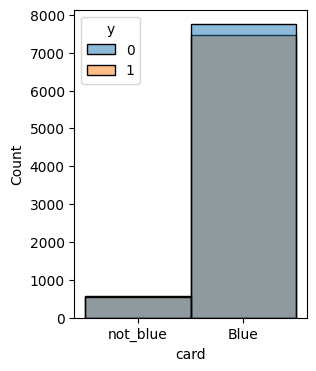

In [12]:
df['card'] = df['card'].replace(['Silver', 'Gold', 'Platinum'], ['not_blue']*3)
plt.figure(figsize = (3,4))
sns.histplot(data=df, x='card', hue='y')
plt.show()

- plot heatmap of categorial data correlation

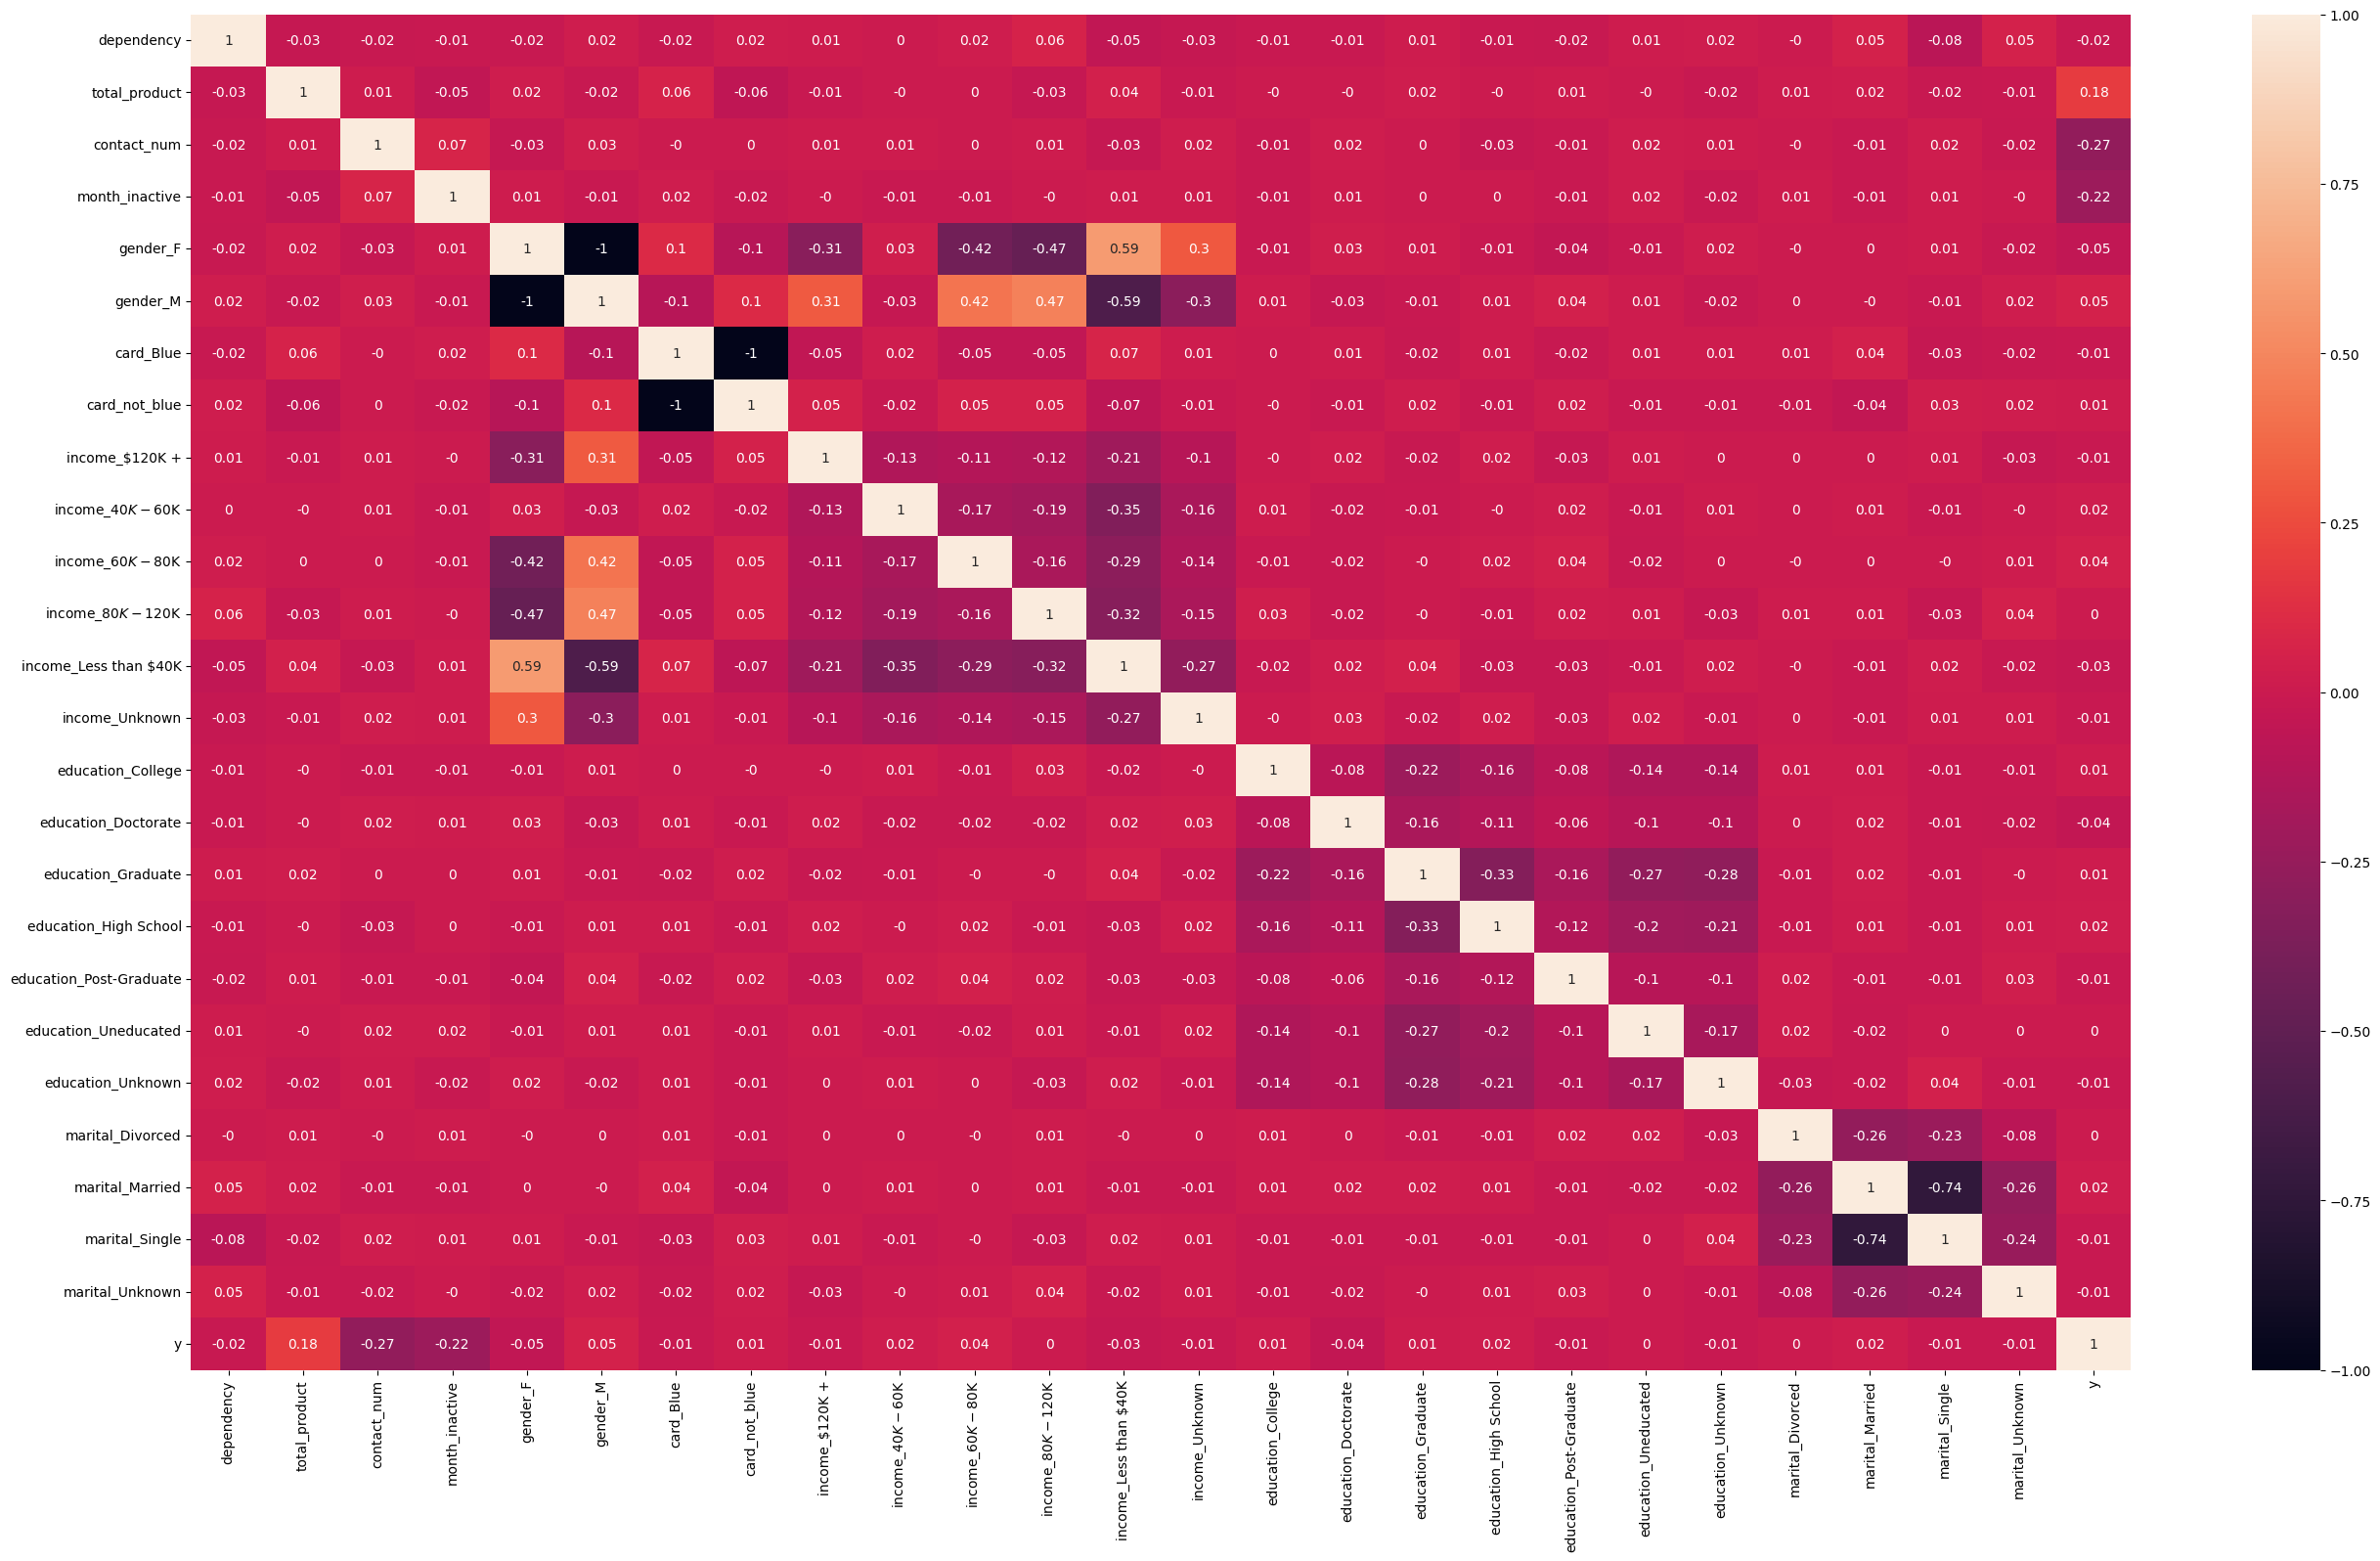

In [13]:
cat_df = df[cat_data]
cat_df = cat_df.drop(['y'],axis=1)
cat_df = pd.get_dummies(cat_df)
cat_df['y'] = df['y']
plt.figure(figsize = (32,18))
sns.heatmap(round(cat_df.corr(), 2), annot=True)
plt.show()

- visualize high correlation to target
<br>

*the feature 'contact_num' and 'month_inactive' some labels have a high ratio of the target but the feature 'total_product' is not obviously show*

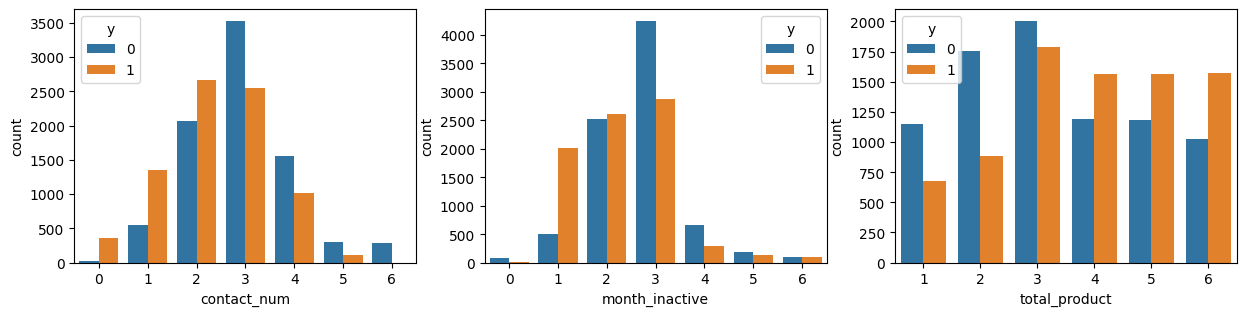

In [14]:
high_corr_data_list = ['contact_num', 'month_inactive', 'total_product']
plot_num = 1
plt.figure(figsize = (15,27))
for i in high_corr_data_list:
    ax = plt.subplot(7, 3, plot_num)
    sns.countplot(data=cat_df, x=i, hue='y')
    plot_num += 1
plt.show()

- visualize relation between categorical data

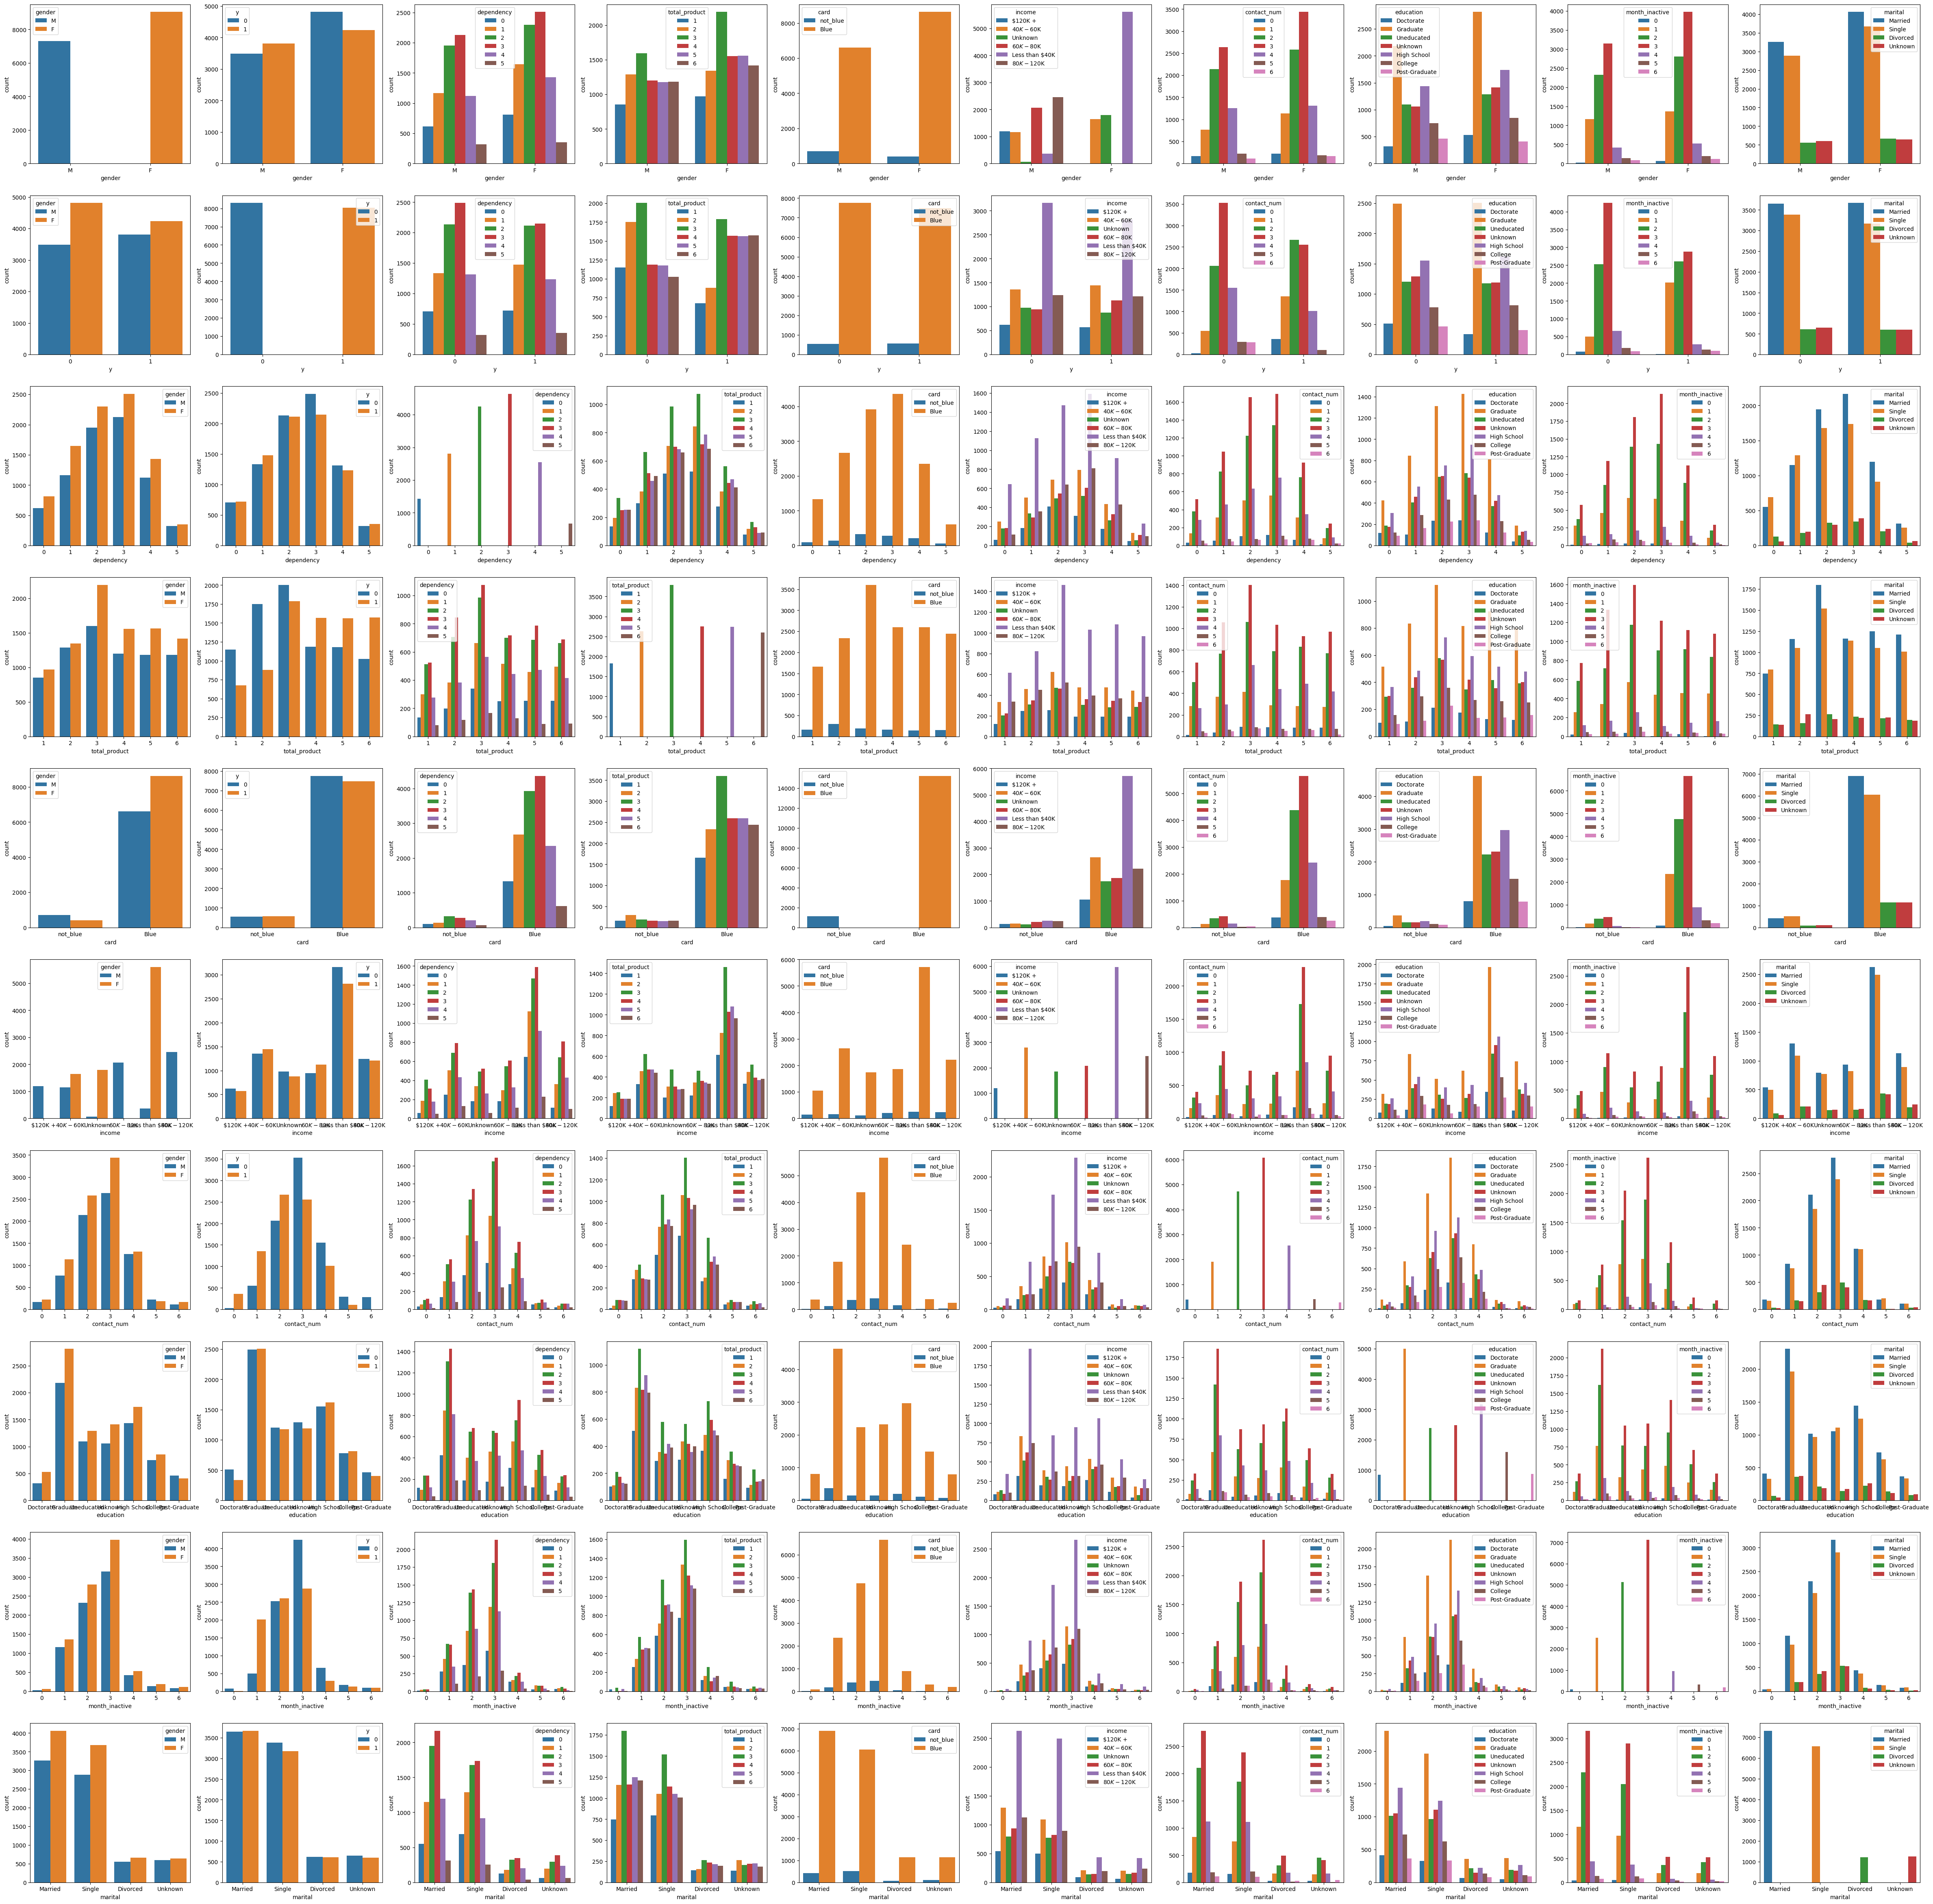

In [15]:
plot_num = 1
plt.figure(figsize = (60,60))
for i in cat_data:
    for j in cat_data:
        ax = plt.subplot(10, 10, plot_num)
        sns.countplot(data=df, x=i, hue=j)
        plot_num += 1
plt.show()

##### visualize relation between categoriacal and numerical data

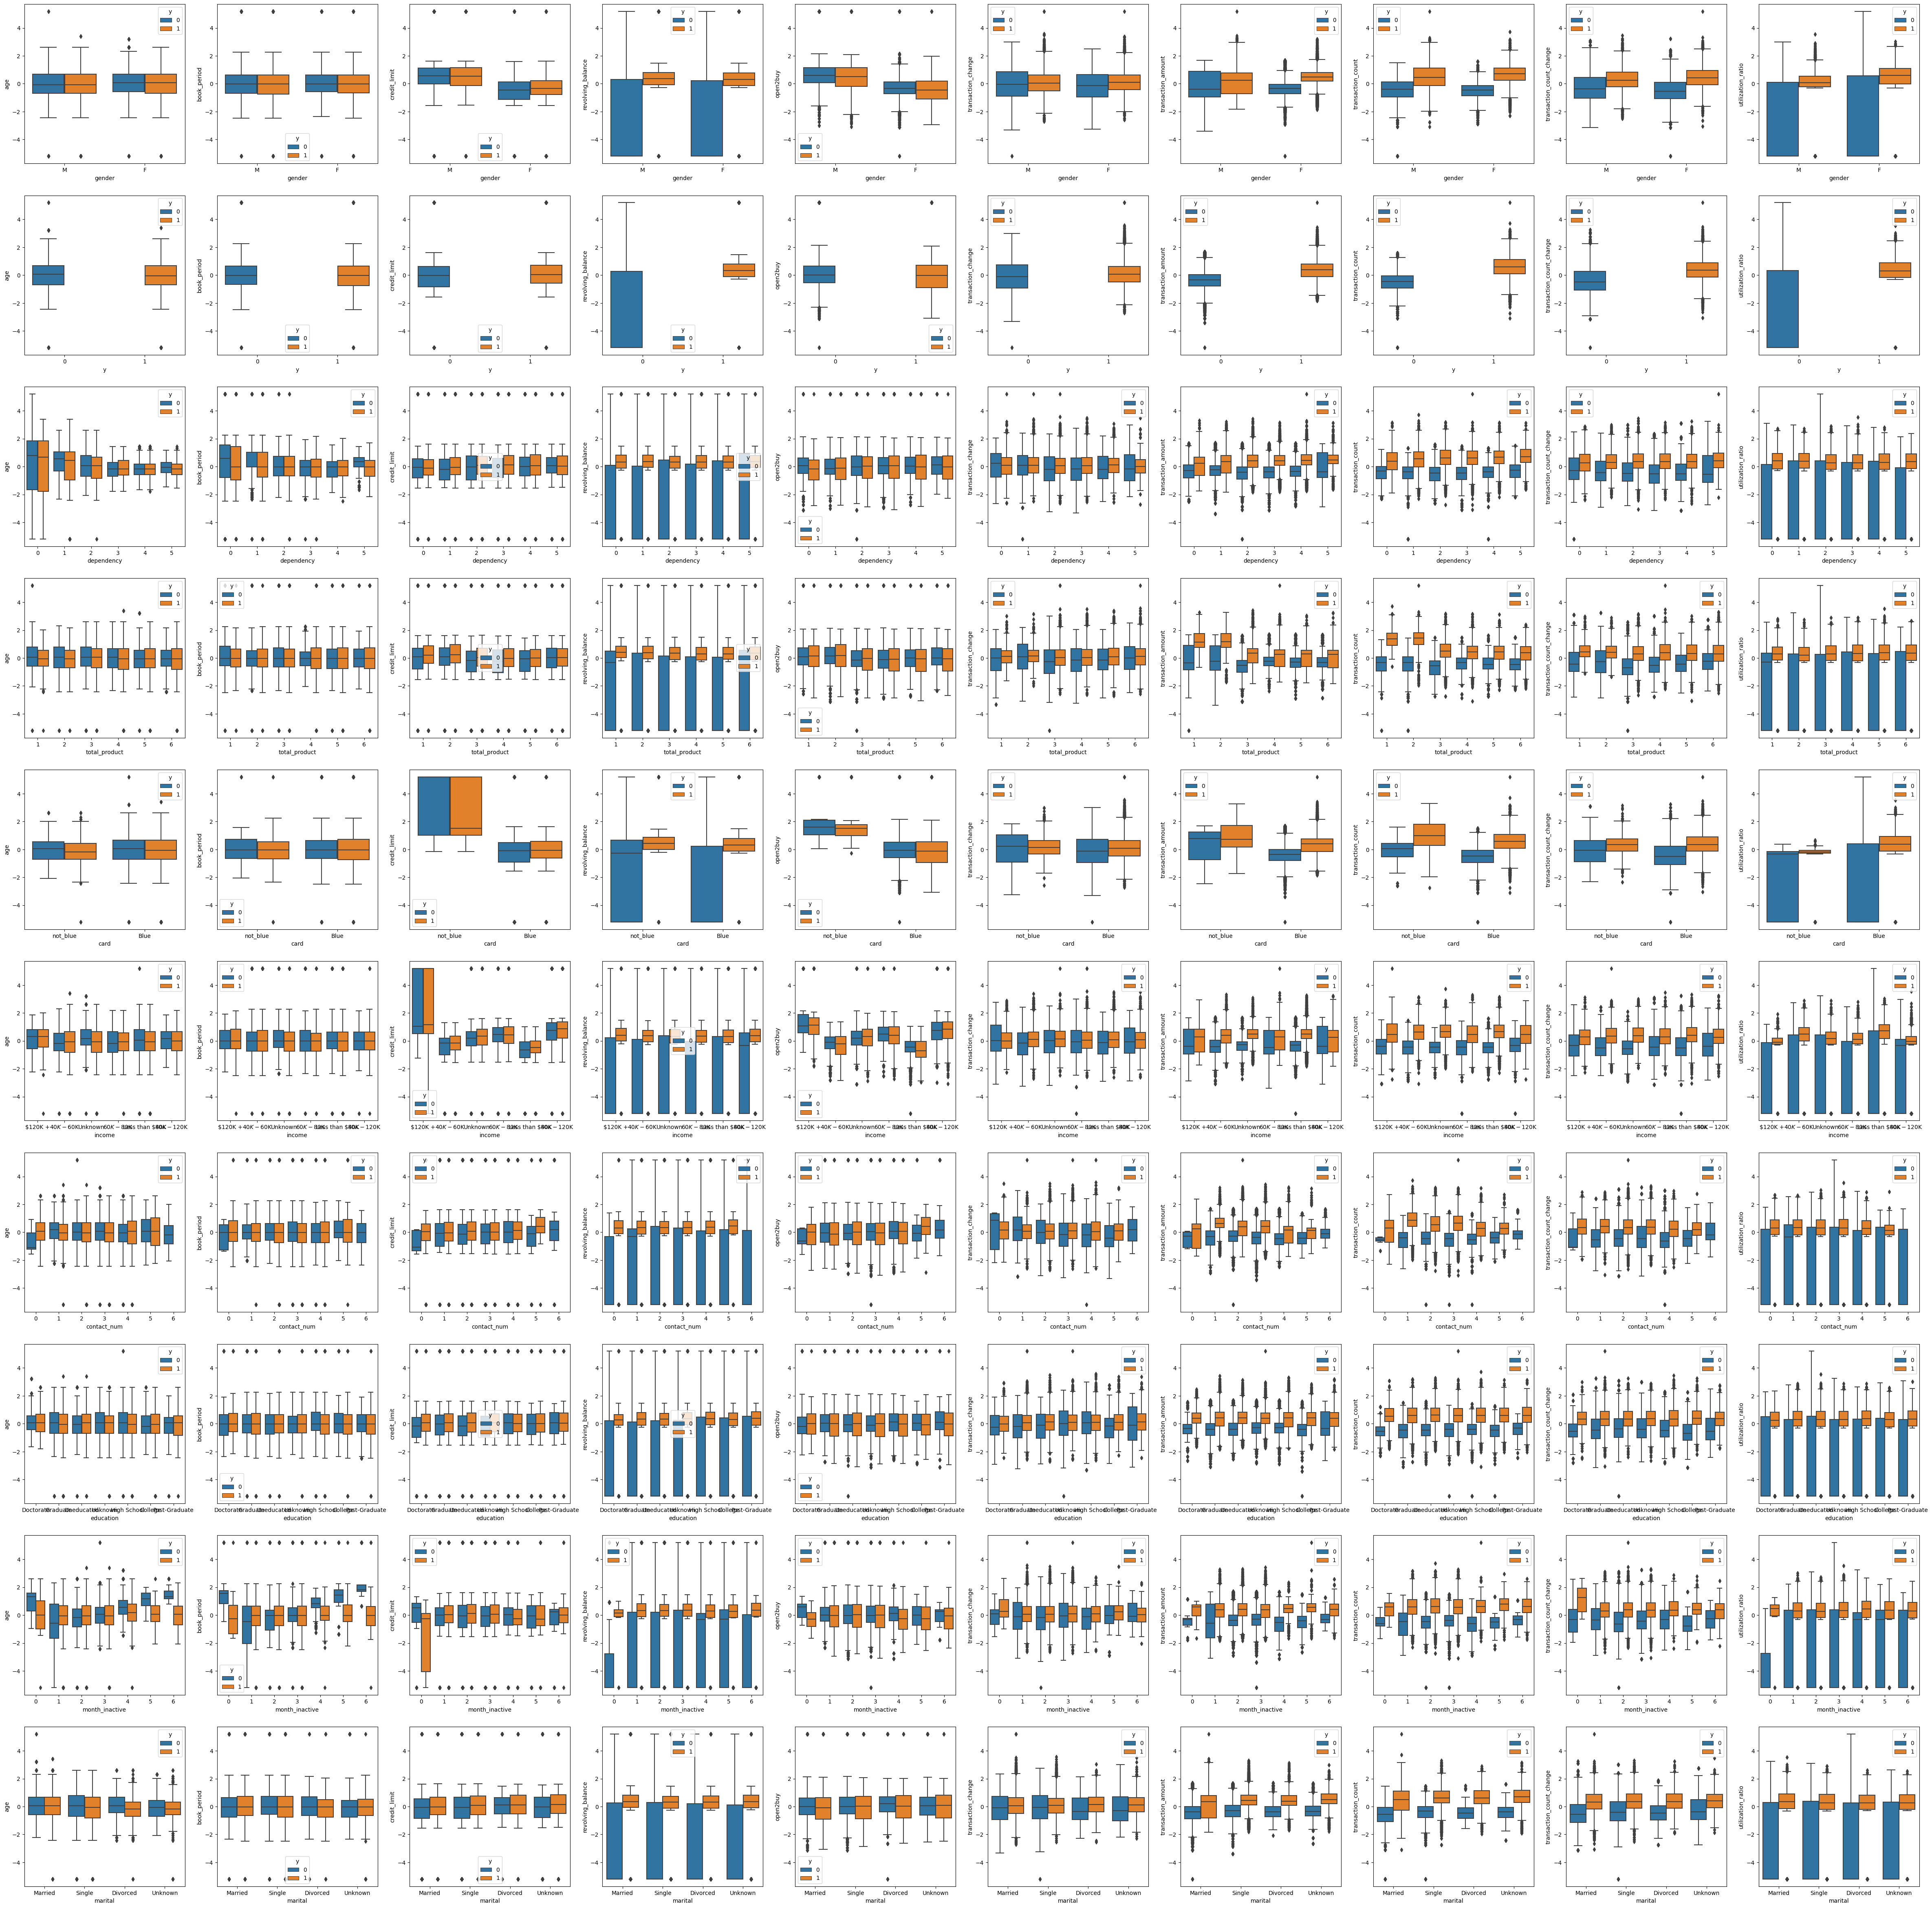

In [16]:
plot_num = 1
plt.figure(figsize = (60,60))
for i in cat_data:
    for j in num_data:
        ax = plt.subplot(10, 10, plot_num)
        sns.boxplot(data=df, x=i, y=j ,hue='y')
        plot_num += 1
plt.show()

##### Data exploration summary

1. upsampling data

2. use IQR to remove outlier

3. use quantile transformer to correct skewed data and standardlize

4. list of numerical features below have a high correlation to the target but when we visualize one thing we realized is some features have close value for each other
    * ['transaction_count', 'transaction_count_change', 'utilization_ratio', 'transaction_amount', 'revolving_balance']

<br>
<br\>

5. list of pair that have the relation between numerical data
    - Utilization_ratio and revolving_balance
    - Transaction_count and transaction_amount
    - Book_period and age
    - Open2buy and credit_limit

<br>
<br\>

6. list of categorical features below have high correlation to the target
    - ['contact_num', 'month_inactive', 'total_product']

### Data Preprocessing


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import classification_report, silhouette_score, v_measure_score, f1_score
%matplotlib widget

RandomState = 1

def importDataset():
    df = pd.read_csv('credit_card_churn.csv')
    df = df.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'CLIENTNUM'], axis=1)
    df = df.rename(columns={'Attrition_Flag': 'y',
                         'Customer_Age': 'age',
                         'Gender': 'gender',
                         'Dependent_count': 'dependency',
                         'Education_Level': 'education',
                         'Marital_Status': 'marital',
                         'Income_Category': 'income',
                         'Card_Category': 'card',
                         'Months_on_book': 'book_period',
                         'Total_Relationship_Count': 'total_product',
                         'Months_Inactive_12_mon': 'month_inactive',
                         'Contacts_Count_12_mon': 'contact_num',
                         'Credit_Limit': 'credit_limit',
                         'Total_Revolving_Bal': 'revolving_balance',
                         'Avg_Open_To_Buy': 'open2buy',
                         'Total_Amt_Chng_Q4_Q1': 'transaction_change',
                         'Total_Trans_Amt': 'transaction_amount',
                         'Total_Trans_Ct': 'transaction_count',
                         'Total_Ct_Chng_Q4_Q1': 'transaction_count_change',
                         'Avg_Utilization_Ratio': 'utilization_ratio',
                         }
    )
    df['y'] = df['y'].replace(['Attrited Customer', 'Existing Customer'], [0, 1])
    return df

def seperateDataType(df): ## return list of numerical and categorical data
    cols = df.columns
    num_data = [i for i in cols if (len(df[i].unique()) > 7 and df[i].dtype != 'object')]
    cat_data = list(set(cols) - set(num_data))
    return num_data, cat_data

def reSampling(df:pd.DataFrame, up_flag:bool, down_flag:bool):
    major_target = df.loc[df['y'] == 1]
    minor_target = df.loc[df['y'] == 0]
    new_df = df.copy()
    if up_flag:
        upsampling_df = resample(minor_target, n_samples=major_target.shape[0], replace=True, random_state=RandomState)
        new_df = pd.concat([major_target, upsampling_df], ignore_index=True)
        new_df = new_df.sample(frac = 1, ignore_index=True)
    elif down_flag:
        downsampling_df = resample(major_target, n_samples=minor_target.shape[0], replace=True, random_state=RandomState)
        new_df = pd.concat([minor_target, downsampling_df], ignore_index=True)
        new_df = new_df.sample(frac = 1, ignore_index=True)
    return new_df

def removeOutlier(df:pd.DataFrame, feature_list:list, flag:bool):
    new_df = df.copy()
    if flag:
        for feature in feature_list:
            q1 = df[feature].quantile(0.25)
            q3 = df[feature].quantile(0.75)
            IQR = q3 - q1
            lower_bound = q1 - 1.5*IQR
            upper_bound = q3 + 1.5*IQR
            new_df = new_df[(new_df[feature]>lower_bound)&(new_df[feature]<upper_bound)]
    return new_df

def correctSkewed(df:pd.DataFrame, skewed_data_list:list, flag:bool):
    new_df = df.copy()
    if flag:
        quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=1)
        x_skew = new_df[skewed_data_list].values
        X_trans = quantile_transformer.fit_transform(x_skew)
        new_df[skewed_data_list] = X_trans
    return new_df

def preprocessData(drop_list:list, 
                    select_list:list, 
                    upsampling_flag:bool = True, 
                    downsampling_flag:bool = True, 
                    remove_outlier_flag:bool = True, 
                    correct_skewed_flag:bool = True):
    df = importDataset()
    df = reSampling(df, upsampling_flag, downsampling_flag)
    outlier_list = ['age', 'transaction_change', 'transaction_count_change']
    df = removeOutlier(df, outlier_list, remove_outlier_flag)
    num_data, cat_data = seperateDataType(df)
    df = correctSkewed(df, num_data, correct_skewed_flag)
    if drop_list is not None:
        df = df.drop(drop_list, axis=1)
    
    if select_list is not None:
        df = df[select_list]
    df_y = df['y']
    df_x = df.drop(['y'], axis=1)
    df_x = pd.get_dummies(df_x)
    x = df_x.values
    y = df_y.values
    scaler = MinMaxScaler()
    x_scale = scaler.fit_transform(x)
    scale_df = pd.DataFrame(x_scale, columns=df_x.columns)
    scale_df['y'] = y
    return x_scale, y, scale_df

### Model Construction and Analysis

In [21]:
def trainK_mean(drop_list:list, 
                    select_list:list, 
                    upsampling_flag:bool = True, 
                    downsampling_flag:bool = True, 
                    remove_outlier_flag:bool = True, 
                    correct_skewed_flag:bool = True):
    ##### get x and y data from preprocessing
    x, y, _ = preprocessData(drop_list, select_list, upsampling_flag, downsampling_flag, remove_outlier_flag, correct_skewed_flag)
    ##### Split train and test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)
    ##### Declare model and model parameters
    model = KMeans(n_clusters=2, max_iter=1000, n_init=1000 , random_state=1)
    parameters = {'init':('k-means++', 'random'),
                  'algorithm':("auto", "full", "elkan")}
    ##### Train model with gridsearchCV and split k-fold = 10
    clf = GridSearchCV(model, parameters, scoring='f1', verbose=3, return_train_score=True, n_jobs=-1, cv = 10)
    clf.fit(x_train, y_train)
    ##### Test model, visualize classification report and confusion matrix
    print(clf.best_params_)
    y_pred = clf.predict(x_test)
    print("K means Classification report \n=======================================================")
    print(classification_report(y_true=y_test, y_pred=y_pred))
    print('=======================================================')
    print(f'silhouette_score: {silhouette_score(x_test, y_pred):0.5f}')
    print(f'v_measure_score: {v_measure_score(y_test, y_pred):0.5f} \n=======================================================')
    return clf

def trainAgglomerative(drop_list:list, 
                    select_list:list, 
                    upsampling_flag:bool = True, 
                    downsampling_flag:bool = True, 
                    remove_outlier_flag:bool = True, 
                    correct_skewed_flag:bool = True):
    ##### get x and y data from preprocessing
    x, y, _ = preprocessData(drop_list, select_list, upsampling_flag, downsampling_flag, remove_outlier_flag, correct_skewed_flag)
    ##### Declare model and model parameters
    method = ['ward', 'complete', 'average', 'single']
    res = {}
    for time, linkage in enumerate(method):
        model = AgglomerativeClustering(n_clusters=2, linkage=linkage)
        y_pred = model.fit_predict(x, y)
        res.update({time:{'model':model,
                        'f1_score':f1_score(y_true=y, y_pred=y_pred),
                        'silhouette_score':silhouette_score(x, y_pred),
                        'v_measure_score':v_measure_score(y, y_pred),
                        'classification_report':classification_report(y_true=y, y_pred=y_pred)}})
        best_model = dict(sorted(res.items(), key=lambda x: x[1]['f1_score'], reverse=True))[0]
    print("{0} Classification report \n=======================================================" .format(best_model['model']))
    print(best_model['classification_report'])
    print('=======================================================')
    print('silhouette_score: {0:0.5f}'.format(best_model['silhouette_score']))
    print('v_measure_score: {0:0.5f} \n=======================================================' .format(best_model['v_measure_score']))
    return best_model

def trainDBSCAN(drop_list:list, 
                    select_list:list,
                    eps_range:list,
                    upsampling_flag:bool = True, 
                    downsampling_flag:bool = True, 
                    remove_outlier_flag:bool = True, 
                    correct_skewed_flag:bool = True,):
    ##### get x and y data from preprocessing
    x, y, _ = preprocessData(drop_list, select_list, upsampling_flag, downsampling_flag, remove_outlier_flag, correct_skewed_flag)
    ##### Declare model and model parameters
    for i in eps_range:
        model = DBSCAN(eps=i, n_jobs=-1)
        y_pred = model.fit_predict(x, y)
        if (max(y_pred) == 1 and min(y_pred) == 0):
            print(f'eps= {i:0.2f} \nDBSCAN Clustering Classification report \n=======================================================')
            print(classification_report(y_true=y, y_pred=y_pred))
            print('=======================================================')
            print(f'silhouette_score: {silhouette_score(x, model.labels_):0.5f}')
            print(f'v_measure_score: {v_measure_score(y, model.labels_):0.5f} \n=======================================================')
            return model
        elif(max(y_pred) == 1 and min(y_pred) == -1):
            print(f'eps= {i:0.2f}')
            print(f'    true label = {Counter(y)}')
            print(f'    pred label = {Counter(y_pred)}')
            print(f'    silhouette_score: {silhouette_score(x, model.labels_):0.5f}')
            print(f'    v_measure_score: {v_measure_score(y, model.labels_):0.5f}')
        elif (max(y_pred) == 0):
            print('the ground truth labels are not available')
            break
        else:
            print(f'eps = {(i):0.2f} given number of class = {max(y_pred)}')

dendogram

In [19]:
# from scipy.cluster.hierarchy import dendrogram
# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
#     def llf(id):
#         return str(id)
#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, labels=y, **kwargs)
    

# plt.figure(figsize = (50,10))
# plot_dendrogram(model, truncate_mode="level", p=10)
# plt.show()

##### EXP 1 preprocessing data

- raw data

In [22]:
drop_list = None
select_list = None
eps_range = np.round(np.arange(1.5, 1.8, 0.01),2)
trainK_mean(drop_list, select_list, upsampling_flag = False, downsampling_flag = False, remove_outlier_flag = False, correct_skewed_flag = False)
trainAgglomerative(drop_list, select_list, upsampling_flag = False, downsampling_flag = False, remove_outlier_flag = False, correct_skewed_flag = False)
trainDBSCAN(drop_list, select_list, eps_range, upsampling_flag = False, downsampling_flag = False, remove_outlier_flag = False, correct_skewed_flag = False)


Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'algorithm': 'auto', 'init': 'k-means++'}
K means Classification report 
              precision    recall  f1-score   support

           0       0.15      0.44      0.23       331
           1       0.83      0.52      0.64      1695

    accuracy                           0.50      2026
   macro avg       0.49      0.48      0.43      2026
weighted avg       0.72      0.50      0.57      2026

silhouette_score: 0.18595
v_measure_score: 0.00086 
AgglomerativeClustering() Classification report 
              precision    recall  f1-score   support

           0       0.15      0.45      0.22      1627
           1       0.83      0.50      0.62      8500

    accuracy                           0.49     10127
   macro avg       0.49      0.47      0.42     10127
weighted avg       0.72      0.49      0.56     10127

silhouette_score: 0.17437
v_measure_score: 0.00126 
eps = 1.50 given number of class = 2
eps= 1.51
    true la

- preprocess data

In [23]:
drop_list = None
select_list = None
eps_range = np.round(np.arange(1.6, 1.8, 0.01),2)
trainK_mean(drop_list, select_list)
trainAgglomerative(drop_list, select_list)
trainDBSCAN(drop_list, select_list, eps_range)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'algorithm': 'auto', 'init': 'random'}
K means Classification report 
              precision    recall  f1-score   support

           0       0.51      0.56      0.54      1648
           1       0.51      0.47      0.49      1621

    accuracy                           0.51      3269
   macro avg       0.51      0.51      0.51      3269
weighted avg       0.51      0.51      0.51      3269

silhouette_score: 0.18851
v_measure_score: 0.00040 
AgglomerativeClustering() Classification report 
              precision    recall  f1-score   support

           0       0.54      0.55      0.54      8298
           1       0.52      0.50      0.51      8043

    accuracy                           0.53     16341
   macro avg       0.53      0.53      0.53     16341
weighted avg       0.53      0.53      0.53     16341

silhouette_score: 0.17701
v_measure_score: 0.00239 
eps = 1.60 given number of class = 3
eps = 1.61 given number 

- analysis


<table style="margin-left:auto;margin-right:auto;">
    <thead>
        <tr>
            <th rowspan=2 colspan=2 style="text-align:center"></th>
            <th colspan=3 style="text-align:center"> KMeans </th>
            <th colspan=3 style="text-align:center"> Agglomerative </th>
            <th colspan=3 style="text-align:center"> DBSCAN </th>
        </tr>
        <tr>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="text-align:center">Class 0</td>
            <td style="text-align:center">raw data</td>
            <td style="text-align:center">0.15</td>
            <td style="text-align:center">0.44</td>
            <td style="text-align:center">0.23</td>
            <td style="text-align:center">0.15</td>
            <td style="text-align:center">0.45</td>
            <td style="text-align:center">0.22</td>
            <td rowspan=2 colspan=3 style="text-align:center"> ground truth labels aren't available </td>
        </tr>
        <tr>
            <td style="text-align:center">preprocess</td>
            <td style="text-align:center">0.53</td>
            <td style="text-align:center">0.59</td>
            <td style="text-align:center">0.55</td>
            <td style="text-align:center">0.54</td>
            <td style="text-align:center">0.55</td>
            <td style="text-align:center">0.54</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">Class 1</td>
            <td style="text-align:center">raw data</td>
            <td style="text-align:center">0.83</td>
            <td style="text-align:center">0.52</td>
            <td style="text-align:center">0.64</td>
            <td style="text-align:center">0.83</td>
            <td style="text-align:center">0.50</td>
            <td style="text-align:center">0.62</td>
            <td rowspan=2 colspan=3 style="text-align:center"> ground truth labels aren't available </td>
        </tr>
        <tr>
            <td style="text-align:center">preprocess</td>
            <td style="text-align:center">0.55</td>
            <td style="text-align:center">0.49</td>
            <td style="text-align:center">0.52</td>
            <td style="text-align:center">0.52</td>
            <td style="text-align:center">0.50</td>
            <td style="text-align:center">0.51</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">Silhouette</td>
            <td style="text-align:center">raw data</td>
            <td colspan=3 style="text-align:center">0.18595</td>
            <td colspan=3 style="text-align:center">0.17437</td>
            <td colspan=3 style="text-align:center">0.11898</td>
        </tr>
        <tr>
            <td style="text-align:center">preprocess</td>
            <td colspan=3 style="text-align:center">0.19064</td>
            <td colspan=3 style="text-align:center">0.17701</td>
            <td colspan=3 style="text-align:center">0.13942</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">V-measure</td>
            <td style="text-align:center">raw data</td>
            <td colspan=3 style="text-align:center">0.00086</td>
            <td colspan=3 style="text-align:center">0.00126</td>
            <td colspan=3 style="text-align:center">0.00049</td>
        </tr>
        <tr>
            <td style="text-align:center">preprocess</td>
            <td colspan=3 style="text-align:center">0.00424</td>
            <td colspan=3 style="text-align:center">0.00239</td>
            <td colspan=3 style="text-align:center">0.00096</td>
        </tr>
    </tbody>
</table>


*as a result shows that the model with raw data has bias due to the dataset's imbalance. when we preprocess the performance for predicting target1 is worse but the model can predict target0 better, in addition, the silhouette score and v-measure score increase a little bit that's because the clustering algorithm needs the feature with the same scale*

##### EXP 2 Select good numeric feature

- Group 1 : numerical data with a high correlation to the target but have a correlation to other feature

In [26]:
drop_list = None
select_list = ['transaction_count', 'transaction_count_change', 'utilization_ratio', 'transaction_amount', 'revolving_balance', 'y']
eps_range = np.round(np.arange(0.3, 4.0, 0.01),2)
trainK_mean(drop_list, select_list)
trainAgglomerative(drop_list, select_list)
trainDBSCAN(drop_list, select_list, eps_range)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'algorithm': 'auto', 'init': 'random'}
K means Classification report 
              precision    recall  f1-score   support

           0       0.75      0.55      0.63      1640
           1       0.64      0.81      0.72      1629

    accuracy                           0.68      3269
   macro avg       0.69      0.68      0.68      3269
weighted avg       0.69      0.68      0.68      3269

silhouette_score: 0.69700
v_measure_score: 0.10750 
AgglomerativeClustering() Classification report 
              precision    recall  f1-score   support

           0       0.37      0.46      0.41      8298
           1       0.25      0.19      0.22      8043

    accuracy                           0.32     16341
   macro avg       0.31      0.32      0.31     16341
weighted avg       0.31      0.32      0.31     16341

silhouette_score: 0.69734
v_measure_score: 0.10307 
eps = 0.30 given number of class = 2
eps = 0.31 given number 

DBSCAN(eps=0.36, n_jobs=-1)

- Group 2 : numerical data with a high correlation to the target and cut feature with a high correlation to other feature

In [25]:
drop_list = None
select_list = ['transaction_count', 'transaction_count_change', 'utilization_ratio', 'y']
eps_range = np.round(np.arange(0.3, 4.0, 0.01),2)
trainK_mean(drop_list, select_list)
trainAgglomerative(drop_list, select_list)
trainDBSCAN(drop_list, select_list, eps_range)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'algorithm': 'auto', 'init': 'k-means++'}
K means Classification report 
              precision    recall  f1-score   support

           0       0.78      0.55      0.65      1666
           1       0.64      0.84      0.73      1603

    accuracy                           0.69      3269
   macro avg       0.71      0.70      0.69      3269
weighted avg       0.71      0.69      0.69      3269

silhouette_score: 0.69110
v_measure_score: 0.12925 
AgglomerativeClustering() Classification report 
              precision    recall  f1-score   support

           0       0.37      0.46      0.41      8298
           1       0.25      0.19      0.22      8043

    accuracy                           0.32     16341
   macro avg       0.31      0.32      0.31     16341
weighted avg       0.31      0.32      0.31     16341

silhouette_score: 0.69326
v_measure_score: 0.10307 
eps= 0.30 
DBSCAN Clustering Classification report 
      

DBSCAN(eps=0.3, n_jobs=-1)

- analysis


<table style="margin-left:auto;margin-right:auto;">
    <thead>
        <tr>
            <th rowspan=2 colspan=2 style="text-align:center"></th>
            <th colspan=3 style="text-align:center"> KMeans </th>
            <th colspan=3 style="text-align:center"> Agglomerative </th>
            <th colspan=3 style="text-align:center"> DBSCAN </th>
        </tr>
        <tr>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="text-align:center">Class 0</td>
            <td style="text-align:center">group 1</td>
            <td style="text-align:center">0.73</td>
            <td style="text-align:center">0.55</td>
            <td style="text-align:center">0.62</td>
            <td style="text-align:center">0.37</td>
            <td style="text-align:center">0.46</td>
            <td style="text-align:center">0.41</td>
            <td style="text-align:center">0.75</td>
            <td style="text-align:center">0.54</td>
            <td style="text-align:center">0.63</td>
        </tr>
        <tr>
            <td style="text-align:center">group 2</td>
            <td style="text-align:center">0.74</td>
            <td style="text-align:center">0.54</td>
            <td style="text-align:center">0.63</td>
            <td style="text-align:center">0.37</td>
            <td style="text-align:center">0.46</td>
            <td style="text-align:center">0.41</td>
            <td style="text-align:center">0.75</td>
            <td style="text-align:center">0.54</td>
            <td style="text-align:center">0.63</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">Class 1</td>
            <td style="text-align:center">group 1</td>
            <td style="text-align:center">0.65</td>
            <td style="text-align:center">0.80</td>
            <td style="text-align:center">0.72</td>
            <td style="text-align:center">0.25</td>
            <td style="text-align:center">0.19</td>
            <td style="text-align:center">0.22</td>
            <td style="text-align:center">0.63</td>
            <td style="text-align:center">0.81</td>
            <td style="text-align:center">0.71</td>
        </tr>
        <tr>
            <td style="text-align:center">group 2</td>
            <td style="text-align:center">0.64</td>
            <td style="text-align:center">0.81</td>
            <td style="text-align:center">0.71</td>
            <td style="text-align:center">0.25</td>
            <td style="text-align:center">0.19</td>
            <td style="text-align:center">0.22</td>
            <td style="text-align:center">0.63</td>
            <td style="text-align:center">0.81</td>
            <td style="text-align:center">0.71</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">Silhouette</td>
            <td style="text-align:center">group 1</td>
            <td colspan=3 style="text-align:center">0.69542</td>
            <td colspan=3 style="text-align:center">0.69734</td>
            <td colspan=3 style="text-align:center">0.69734</td>
        </tr>
        <tr>
            <td style="text-align:center">group 2</td>
            <td colspan=3 style="text-align:center">0.69153</td>
            <td colspan=3 style="text-align:center">0.69326</td>
            <td colspan=3 style="text-align:center">0.69326</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">V-measure</td>
            <td style="text-align:center">group 1</td>
            <td colspan=3 style="text-align:center">0.10000</td>
            <td colspan=3 style="text-align:center">0.10307</td>
            <td colspan=3 style="text-align:center">0.10307</td>
        </tr>
        <tr>
            <td style="text-align:center">group 2</td>
            <td colspan=3 style="text-align:center">0.10129</td>
            <td colspan=3 style="text-align:center">0.10307</td>
            <td colspan=3 style="text-align:center">0.10307</td>
        </tr>
    </tbody>
</table>


*as a result shows the performance of two models that's not much different and the performance of the both Agglomerative model is really worse than all feature models*

- visualize group2 features

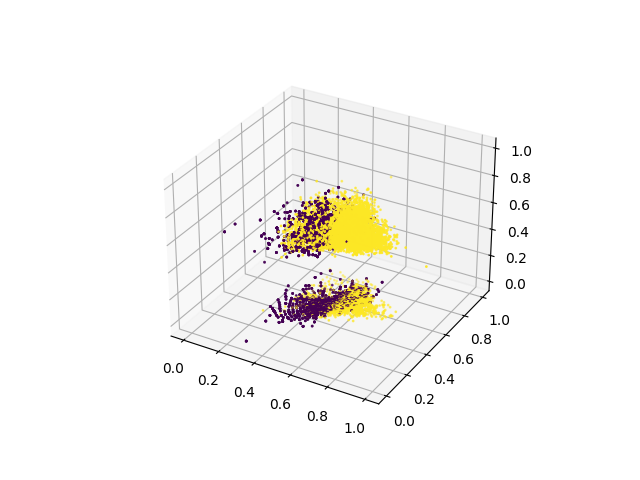

In [46]:
%matplotlib widget

_, _, scale_df = preprocessData(None, None)
select_list = ['transaction_count', 'transaction_count_change', 'utilization_ratio', 'y']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = scale_df['transaction_count']
y = scale_df['transaction_count_change']
z = scale_df['utilization_ratio']
ax.scatter(x, y, z, c=scale_df['y'], s=1)
plt.show()

*from 3D visualization we will see 2 clusters that affect by utilization ratio feature, those 2 clusters are full out of 2 targets,s and two clusters is far from each other so we guess we can cut the utilization ratio to improve the performance of the clustering model*

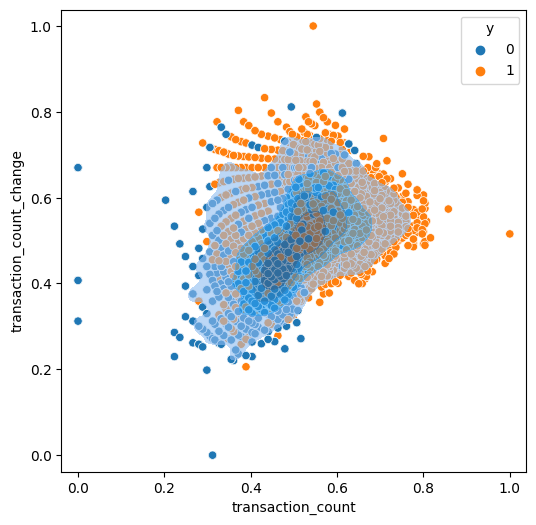

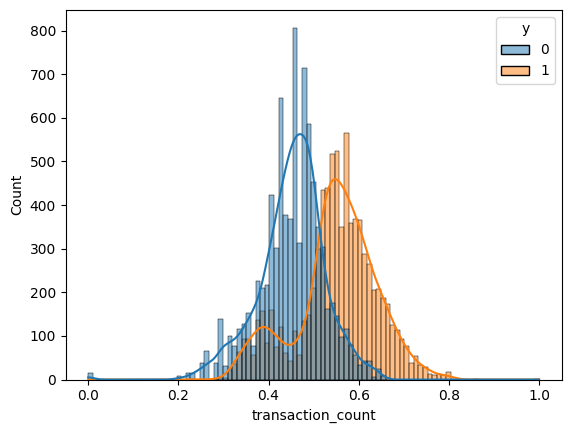

In [41]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=scale_df, x="transaction_count", y="transaction_count_change", hue="y", ax=ax,)
sns.kdeplot(data=scale_df, x="transaction_count", y="transaction_count_change", levels=5, fill=True, alpha=0.6, cut=2, ax=ax,)
plt.show()

##### EXP 3 Prove assumption from experiment 2

In [35]:
drop_list = None
select_list = ['transaction_count', 'transaction_count_change', 'y']
eps_range = np.round(np.arange(0.2, 4.0, 0.01),2)
trainK_mean(drop_list, select_list)
trainAgglomerative(drop_list, select_list)
trainDBSCAN(drop_list, select_list, eps_range)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'algorithm': 'auto', 'init': 'k-means++'}
K means Classification report 
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      1663
           1       0.75      0.78      0.77      1606

    accuracy                           0.76      3269
   macro avg       0.76      0.76      0.76      3269
weighted avg       0.76      0.76      0.76      3269

silhouette_score: 0.44110
v_measure_score: 0.21240 
AgglomerativeClustering() Classification report 
              precision    recall  f1-score   support

           0       0.79      0.67      0.73      8298
           1       0.71      0.82      0.76      8043

    accuracy                           0.74     16341
   macro avg       0.75      0.75      0.74     16341
weighted avg       0.75      0.74      0.74     16341

silhouette_score: 0.42844
v_measure_score: 0.18819 
eps = 0.20 given number of class = 2
eps = 0.21 given numb

DBSCAN(eps=0.22, n_jobs=-1)

- analysis


<table style="margin-left:auto;margin-right:auto;">
    <thead>
        <tr>
            <th rowspan=2 colspan=2 style="text-align:center"></th>
            <th colspan=3 style="text-align:center"> KMeans </th>
            <th colspan=3 style="text-align:center"> Agglomerative </th>
            <th colspan=3 style="text-align:center"> DBSCAN </th>
        </tr>
        <tr>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
            <th style="text-align:center"> precision </th>
            <th style="text-align:center"> recall </th>
            <th style="text-align:center"> f1-score </th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td rowspan=2 style="text-align:center">Class 0</td>
            <td style="text-align:center">EXP2</td>
            <td style="text-align:center">0.74</td>
            <td style="text-align:center">0.54</td>
            <td style="text-align:center">0.63</td>
            <td style="text-align:center">0.37</td>
            <td style="text-align:center">0.46</td>
            <td style="text-align:center">0.41</td>
            <td style="text-align:center">0.75</td>
            <td style="text-align:center">0.54</td>
            <td style="text-align:center">0.63</td>
        </tr>
        <tr>
            <td style="text-align:center">EXP3</td>
            <td style="text-align:center">0.78</td>
            <td style="text-align:center">0.74</td>
            <td style="text-align:center">0.76</td>
            <td style="text-align:center">0.79</td>
            <td style="text-align:center">0.67</td>
            <td style="text-align:center">0.73</td>
            <td style="text-align:center">0.51</td>
            <td style="text-align:center">1.00</td>
            <td style="text-align:center">0.67</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">Class 1</td>
            <td style="text-align:center">EXP2</td>
            <td style="text-align:center">0.64</td>
            <td style="text-align:center">0.81</td>
            <td style="text-align:center">0.71</td>
            <td style="text-align:center">0.25</td>
            <td style="text-align:center">0.19</td>
            <td style="text-align:center">0.22</td>
            <td style="text-align:center">0.63</td>
            <td style="text-align:center">0.81</td>
            <td style="text-align:center">0.71</td>
        </tr>
        <tr>
            <td style="text-align:center">EXP3</td>
            <td style="text-align:center">0.75</td>
            <td style="text-align:center">0.78</td>
            <td style="text-align:center">0.77</td>
            <td style="text-align:center">0.71</td>
            <td style="text-align:center">0.82</td>
            <td style="text-align:center">0.76</td>
            <td style="text-align:center">0.00</td>
            <td style="text-align:center">0.00</td>
            <td style="text-align:center">0.00</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">Silhouette</td>
            <td style="text-align:center">EXP2</td>
            <td colspan=3 style="text-align:center">0.69153</td>
            <td colspan=3 style="text-align:center">0.69326</td>
            <td colspan=3 style="text-align:center">0.69326</td>
        </tr>
        <tr>
            <td style="text-align:center">EXP3</td>
            <td colspan=3 style="text-align:center">0.44110</td>
            <td colspan=3 style="text-align:center">0.42844</td>
            <td colspan=3 style="text-align:center">0.66724</td>
        </tr>
        <tr>
            <td rowspan=2 style="text-align:center">V-measure</td>
            <td style="text-align:center">EXP2</td>
            <td colspan=3 style="text-align:center">0.10129</td>
            <td colspan=3 style="text-align:center">0.10307</td>
            <td colspan=3 style="text-align:center">0.10307</td>
        </tr>
        <tr>
            <td style="text-align:center">EXP3</td>
            <td colspan=3 style="text-align:center">0.21240</td>
            <td colspan=3 style="text-align:center">0.18819</td>
            <td colspan=3 style="text-align:center">0.00119</td>
        </tr>
    </tbody>
</table>


*as a result shows the performance of two models that are obviously different*
<br>

***K Means:** is increasing a little bit*
<br>

***Agglomerative:** obviously sees the difference. the performance looks pretty good*
<br>

***DBSCAN:** gives a bad result thus, two feature is not appropriate to the DBSCAN algorithm*

- visualization

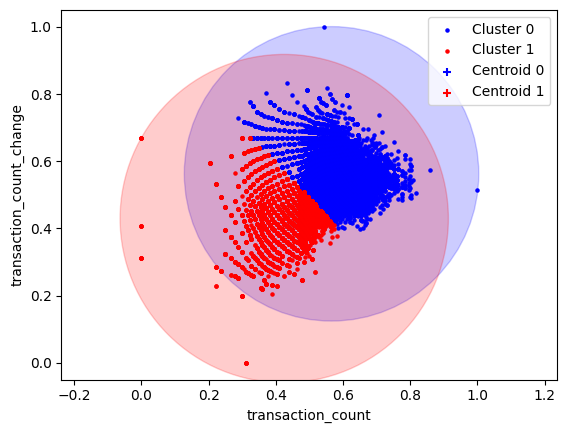

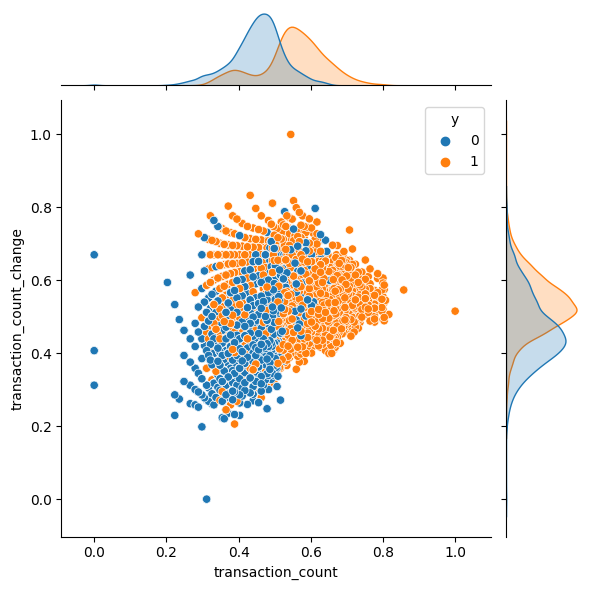

In [58]:
%matplotlib inline

drop_list = None
select_list = ['transaction_count', 'transaction_count_change', 'y']
_, _, scale_df = preprocessData(drop_list, select_list)
kmeans = KMeans(n_clusters=2, max_iter=1000, n_init=5000 , random_state=1)
model = kmeans.fit(scale_df[['transaction_count','transaction_count_change']])

def get_distance(X,Y,x_point,y_point):
  return np.sort(np.sqrt((X-x_point)**2 + (Y-y_point)**2))
  
#Plot results
Cluster0 = scale_df[model.labels_ == 0]
Cluster1 = scale_df[model.labels_ == 1]

cx1,cy1 = model.cluster_centers_[0]
cx2,cy2 = model.cluster_centers_[1]

distance1 = get_distance(Cluster0['transaction_count'],Cluster0['transaction_count_change'],cx1,cy1)
distance2 = get_distance(Cluster1['transaction_count'],Cluster1['transaction_count_change'],cx2,cy2)

radious1 = max(distance1)
radious2 = max(distance2)

plt.xlabel('transaction_count')
plt.ylabel('transaction_count_change')
plt.axis('equal')

circle1 = plt.Circle((cx1,cy1),radious1,alpha=0.2,color='b')
plt.gcf().gca().add_artist(circle1)
circle2 = plt.Circle((cx2,cy2),radious2,alpha=0.2,color='r')
plt.gcf().gca().add_artist(circle2)

plt.scatter(Cluster0['transaction_count'],Cluster0['transaction_count_change'],c='b',label = 'Cluster 0', s=5)
plt.scatter(Cluster1['transaction_count'],Cluster1['transaction_count_change'],c='r',label = 'Cluster 1', s=5)
plt.scatter(cx1,cy1,c='b',marker='+',label='Centroid 0')
plt.scatter(cx2,cy2,c='r',marker='+',label='Centroid 1')
plt.legend()
plt.show()

sns.jointplot(data=scale_df, x="transaction_count", y="transaction_count_change", hue="y")
plt.show()